In [ ]:
!pip install awscli
!aws s3 cp s3://openneuro.org/ds003097/participants.tsv participants.tsv --no-sign-request


download: s3://openneuro.org/ds003097/participants.tsv to ./participants.tsv


In [ ]:
import pandas as pd

df = pd.read_csv('participants.tsv', sep='\t')
print(df.columns)


Index(['participant_id', 'age', 'sex', 'handedness', 'BMI', 'education_level',
       'background_SES', 'IST_fluid', 'IST_memory', 'IST_crystallised',
       'IST_intelligence_total', 'BAS_drive', 'BAS_fun', 'BAS_reward', 'BIS',
       'NEO_N', 'NEO_E', 'NEO_O', 'NEO_A', 'NEO_C', 'STAI_T',
       'sexual_attraction_M', 'sexual_attraction_F', 'gender_identity_M',
       'gender_identity_F', 'religious_upbringing', 'religious_now',
       'religious_importance', 'DWI_TR_run1', 'DWI_TR_run2', 'DWI_TR_run3'],
      dtype='object')


In [ ]:
from subprocess import run
import os

subjects = df['participant_id'].tolist()
os.makedirs("seg", exist_ok=True)

for sub in subjects:
    gm_s3 = f"s3://openneuro.org/ds003097/derivatives/fmriprep/{sub}/anat/{sub}_label-GM_probseg.nii.gz"
    wm_s3 = f"s3://openneuro.org/ds003097/derivatives/fmriprep/{sub}/anat/{sub}_label-WM_probseg.nii.gz"
    run(["aws", "s3", "cp", gm_s3, f"seg/{sub}_GM.nii.gz", "--no-sign-request"])
    run(["aws", "s3", "cp", wm_s3, f"seg/{sub}_WM.nii.gz", "--no-sign-request"])


In [ ]:
import nibabel as nib
import numpy as np

vols = []
for sub in subjects:
    gm_img = nib.load(f"seg/{sub}_GM.nii.gz")
    wm_img = nib.load(f"seg/{sub}_WM.nii.gz")
    gm_data = gm_img.get_fdata()
    wm_data = wm_img.get_fdata()
    voxel_vol = np.prod(gm_img.header.get_zooms())
    gm_vol = gm_data.sum() * voxel_vol
    wm_vol = wm_data.sum() * voxel_vol
    vols.append({'participant_id': sub, 'GM_vol': gm_vol, 'WM_vol': wm_vol})

vol_df = pd.DataFrame(vols)
vol_df.head()


participant_id         GM_vol         WM_vol
0       sub-0001  509986.601442  512174.867482
1       sub-0002  492229.254208  451637.843634
2       sub-0003  453713.824605  468193.795755
3       sub-0004  536892.579551  506908.625462
4       sub-0005  605392.368507  628862.401582

In [ ]:
import pandas as pd

df = pd.read_csv('participants.tsv', sep='\t')

final_df = pd.merge(df, vol_df, on='participant_id', how='inner')

final_df.to_csv('AOMIC_ID1000_combined.csv', index=False)




Fusion réussie ! 928 participants combinés.


In [ ]:
final_df.columns


Index(['participant_id', 'age', 'sex', 'handedness', 'BMI', 'education_level',
       'background_SES', 'IST_fluid', 'IST_memory', 'IST_crystallised',
       'IST_intelligence_total', 'BAS_drive', 'BAS_fun', 'BAS_reward', 'BIS',
       'NEO_N', 'NEO_E', 'NEO_O', 'NEO_A', 'NEO_C', 'STAI_T',
       'sexual_attraction_M', 'sexual_attraction_F', 'gender_identity_M',
       'gender_identity_F', 'religious_upbringing', 'religious_now',
       'religious_importance', 'DWI_TR_run1', 'DWI_TR_run2', 'DWI_TR_run3',
       'GM_vol', 'WM_vol'],
      dtype='object')

KeyError: ['GM_vol']

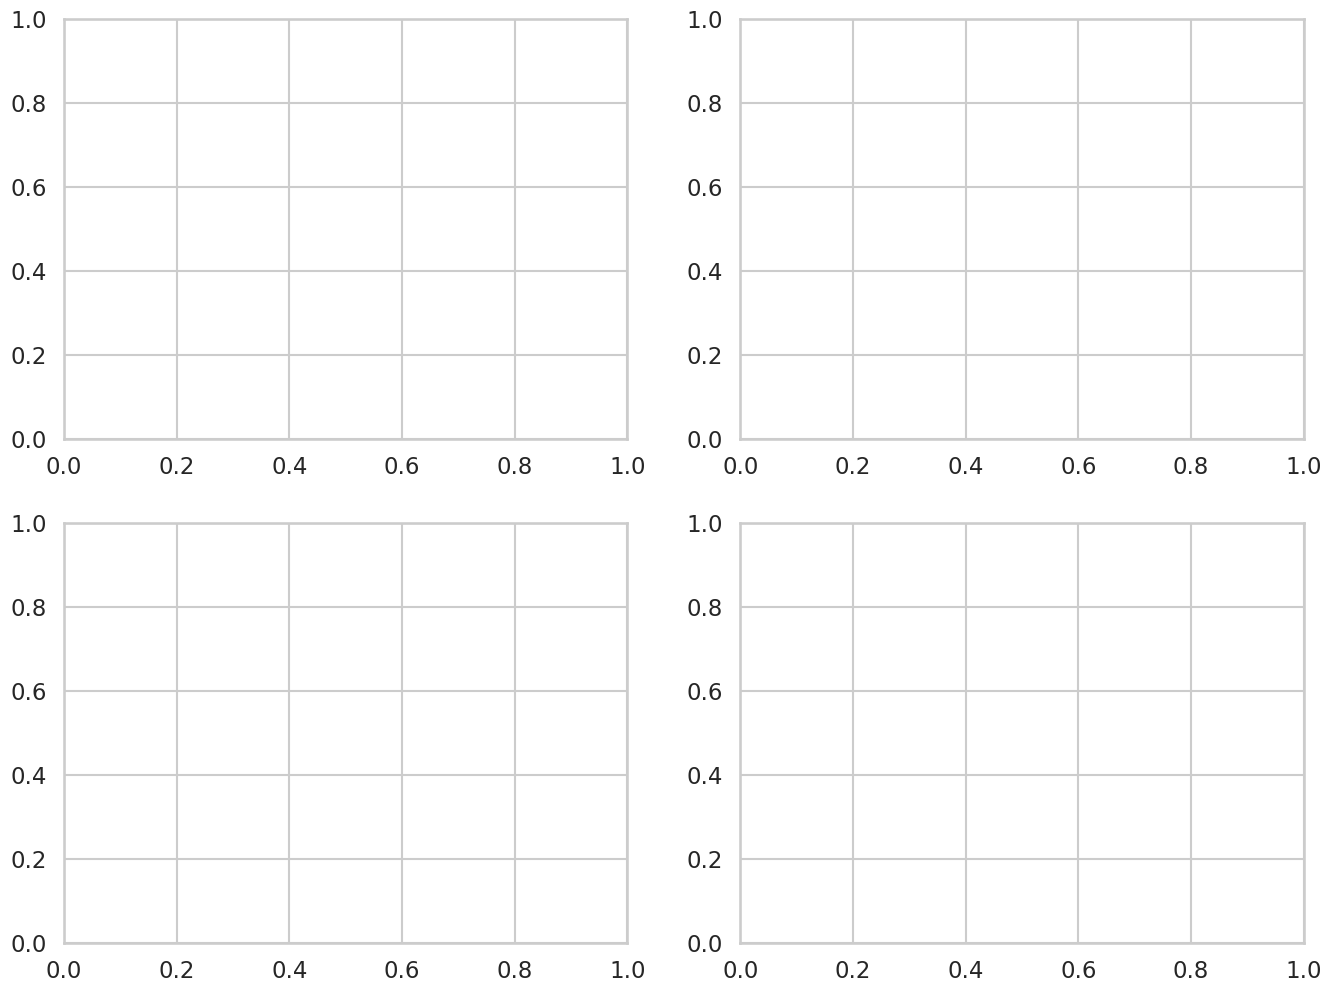

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("AOMIC_ID1000_combined.csv")

sns.set(style="whitegrid", context="talk")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

def plot_poly_and_linear(ax, x, y, data, color, title):

    cleaned_data = data.dropna(subset=[x, y])

    sns.scatterplot(data=cleaned_data, x=x, y=y, ax=ax, color=color, alpha=0.6, edgecolor=None)

    sns.regplot(data=cleaned_data, x=x, y=y, ax=ax, scatter=False,
                line_kws={'color': 'black', 'linestyle': '--'}, ci=None)


    if len(cleaned_data) > 2:
        x_vals_fit = cleaned_data[x]
        y_vals_fit = cleaned_data[y]
        x_vals_plot = np.linspace(x_vals_fit.min(), x_vals_fit.max(), 200)
        coeffs = np.polyfit(x_vals_fit, y_vals_fit, deg=2)
        y_vals_plot = np.polyval(coeffs, x_vals_plot)
        ax.plot(x_vals_plot, y_vals_plot, color='black', linestyle='--', linewidth=2, label="Quadratic fit")
    else:
        print(f"shit")


    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y.replace('_', ' ') + " (mm³)")
    ax.legend()

plot_poly_and_linear(axs[0, 0], 'IST_fluid', 'GM_vol', df, 'skyblue', 'GM volume vs IST_fluid')

plot_poly_and_linear(axs[0, 1], 'IST_fluid', 'WM_vol', df, 'lightgreen', 'WM volume vs IST_fluid')

plot_poly_and_linear(axs[1, 0], 'IST_intelligence_total', 'GM_vol', df, 'orange', 'GM volume vs IST_total')

plot_poly_and_linear(axs[1, 1], 'IST_intelligence_total', 'WM_vol', df, 'salmon', 'WM volume vs IST_total')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Charger les données
df = pd.read_csv("AOMIC_ID1000_combined.csv")

sns.set(style="whitegrid", context="talk")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

def plot_quartic_and_linear(ax, x, y, data, color, title):
    cleaned_data = data.dropna(subset=[x, y])

    sns.scatterplot(data=cleaned_data, x=x, y=y, ax=ax, color=color, alpha=0.6, edgecolor=None)

    sns.regplot(data=cleaned_data, x=x, y=y, ax=ax, scatter=False,
                line_kws={'color': 'black', 'linestyle': '--'}, ci=None)

    if len(cleaned_data) > 4:
        x_vals = cleaned_data[x]
        y_vals = cleaned_data[y]
        x_plot = np.linspace(x_vals.min(), x_vals.max(), 300)
        coeffs = np.polyfit(x_vals, y_vals, deg=4)
        y_plot = np.polyval(coeffs, x_plot)
        ax.plot(x_plot, y_plot, color=color, linewidth=3, label='Quartic fit (deg=4)')
    else:
        print(f"Pas assez de points pour fit quartique pour {title}")

    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y.replace('_', ' ') + " (mm³)")
    ax.legend()

plot_quartic_and_linear(axs[0, 0], 'IST_fluid', 'GM_vol', df, 'skyblue', 'GM volume vs IST_fluid')

plot_quartic_and_linear(axs[0, 1], 'IST_fluid', 'WM_vol', df, 'lightgreen', 'WM volume vs IST_fluid')

plot_quartic_and_linear(axs[1, 0], 'IST_intelligence_total', 'GM_vol', df, 'orange', 'GM volume vs IST_total')

plot_quartic_and_linear(axs[1, 1], 'IST_intelligence_total', 'WM_vol', df, 'salmon', 'WM volume vs IST_total')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("AOMIC_ID1000_combined.csv")

df['WhiteGreyMRatio'] = df['WM_vol'] / df['GM_vol']

df.to_csv("AOMIC_ID1000_V2_combined.csv", index=False)

NaN count in df_long columns:
WhiteGreyMRatio    0
IST_score          8
participant_id     0
dtype: int64
Nombre de participants uniques dans df_long: 928
Nombre total de lignes dans df_long: 3712
Sexes trouvés : ['female' 'male']
Modèle mixte non exécuté : index 3704 is out of bounds for axis 0 with size 3704


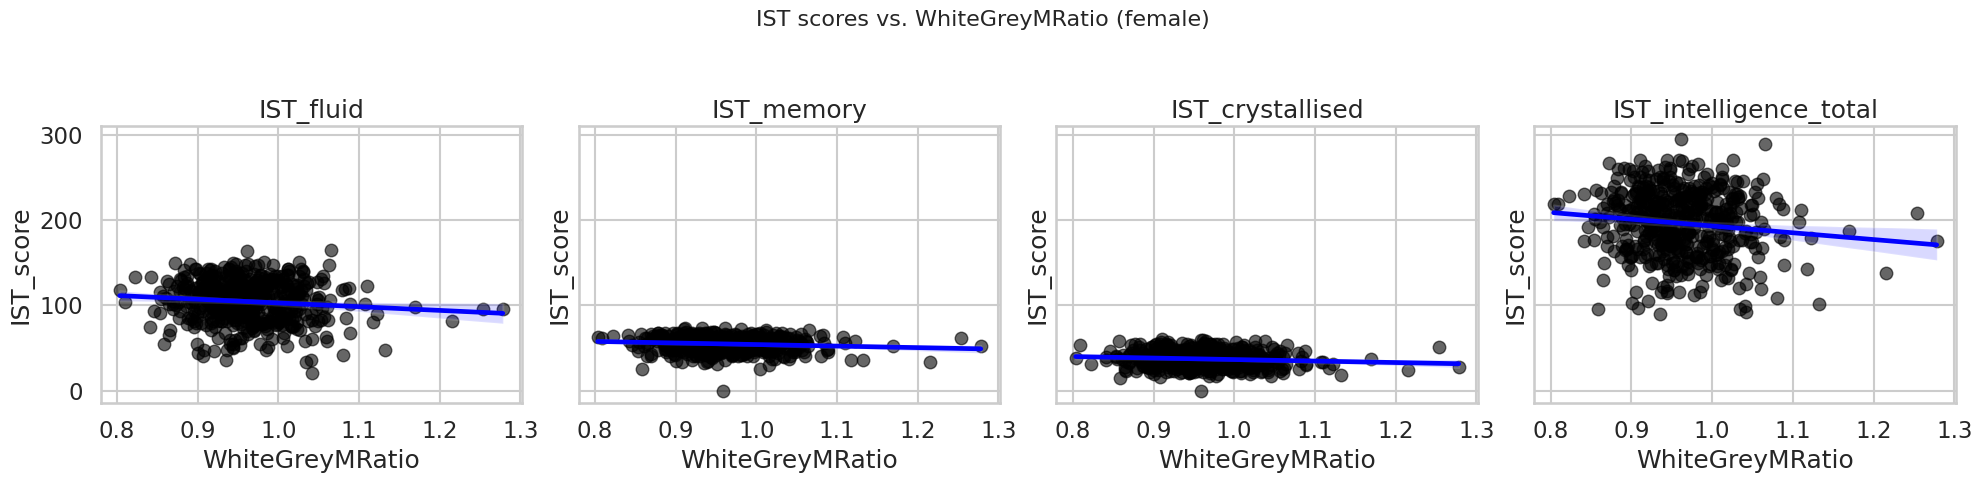

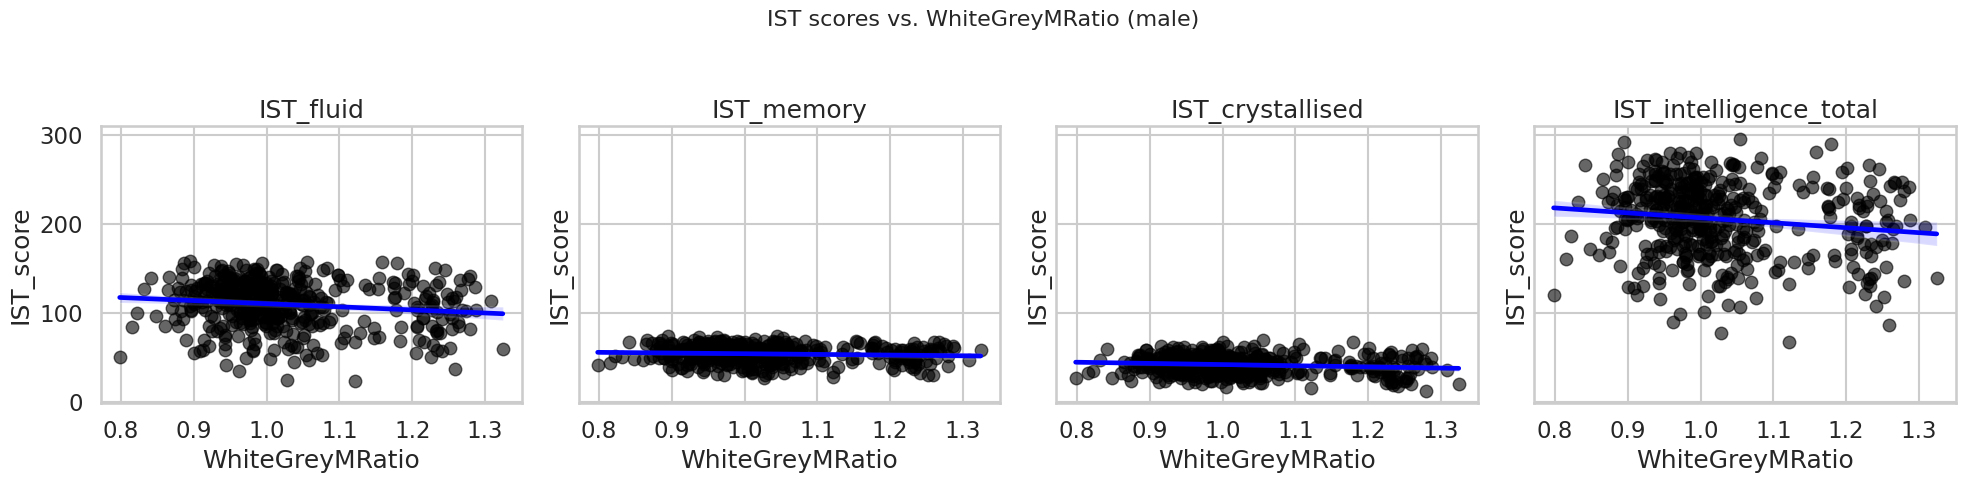

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

df = pd.read_csv("AOMIC_ID1000_combined.csv")

df['WhiteGreyMRatio'] = df['WM_vol'] / df['GM_vol']

ist_cols = ['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total']

df_long = df.melt(id_vars=['participant_id', 'sex', 'WhiteGreyMRatio'],
                  value_vars=ist_cols,
                  var_name='IST_type', value_name='IST_score')

print("NaN count in df_long columns:")
print(df_long[['WhiteGreyMRatio', 'IST_score', 'participant_id']].isna().sum())
print(f"Nombre de participants uniques dans df_long: {df_long['participant_id'].nunique()}")
print(f"Nombre total de lignes dans df_long: {len(df_long)}")
print(f"Sexes trouvés : {df_long['sex'].unique()}")

try:
    md = smf.mixedlm("IST_score ~ WhiteGreyMRatio * IST_type",
                     df_long,
                     groups=df_long["participant_id"])
    mdf = md.fit()
    print(mdf.summary())
except Exception as e:
    print(f"Modèle mixte non exécuté : {e}")


if 'df_long' in locals():
    sexes = df_long['sex'].unique()
    ist_types = df_long['IST_type'].unique()

    for sex in sexes:
        df_sex = df_long[df_long['sex'] == sex]

        fig, axes = plt.subplots(1, len(ist_types), figsize=(20, 5), sharey=True)

        for ax, ist in zip(axes, ist_types):
            data = df_sex[df_sex['IST_type'] == ist]
            sns.regplot(
                data=data,
                x='WhiteGreyMRatio',
                y='IST_score',
                scatter_kws={'color': 'black', 'alpha': 0.6},
                line_kws={'color': 'blue'},
                ax=ax
            )
            ax.set_title(ist)
            ax.set_xlabel('WhiteGreyMRatio')
            ax.set_ylabel('IST_score')

        fig.suptitle(f'IST scores vs. WhiteGreyMRatio ({sex})', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

else:
    print("df_long n'a pas été créé, impossible de tracer les graphiques séparés.")


Sexes présents dans les données : ['female' 'male']


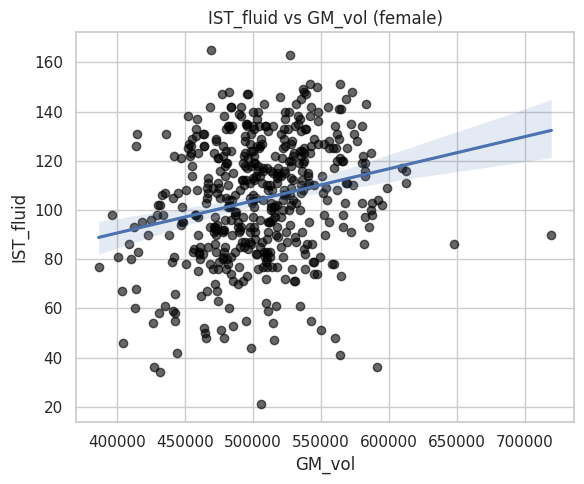

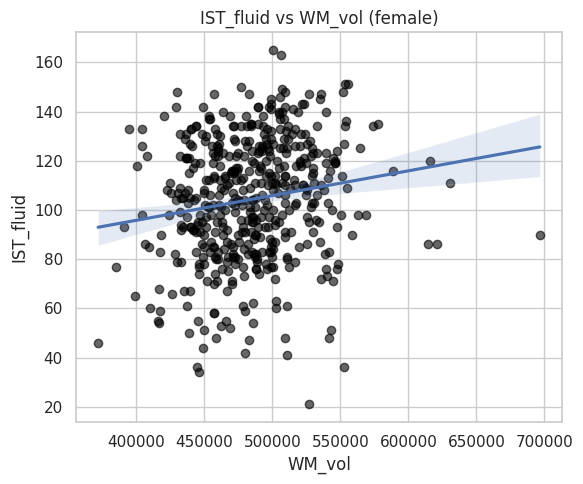

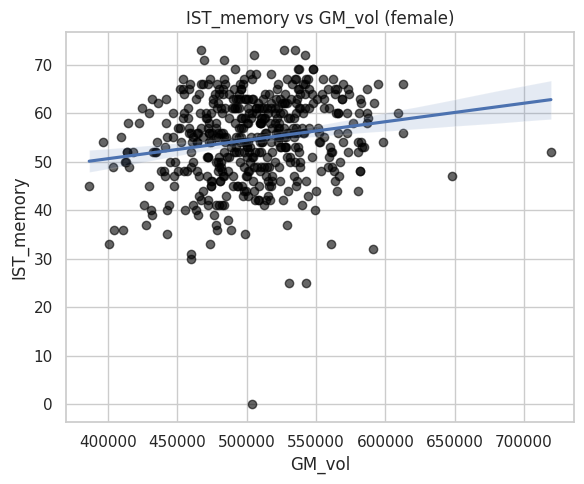

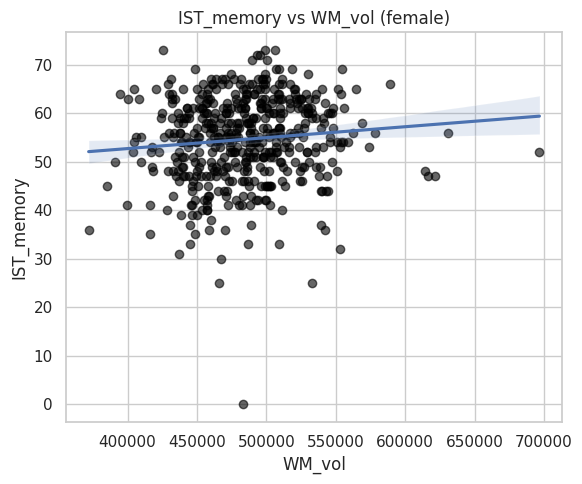

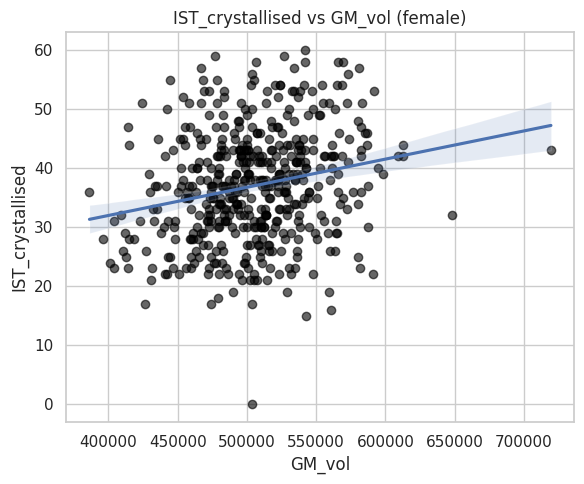

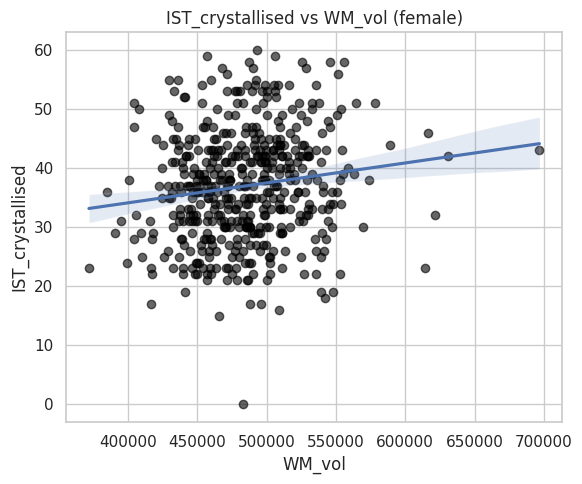

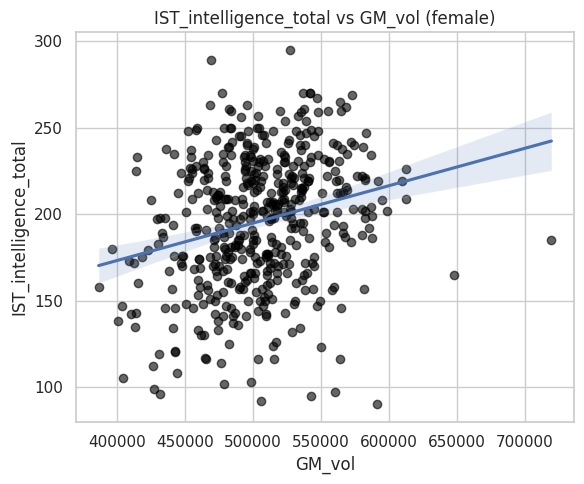

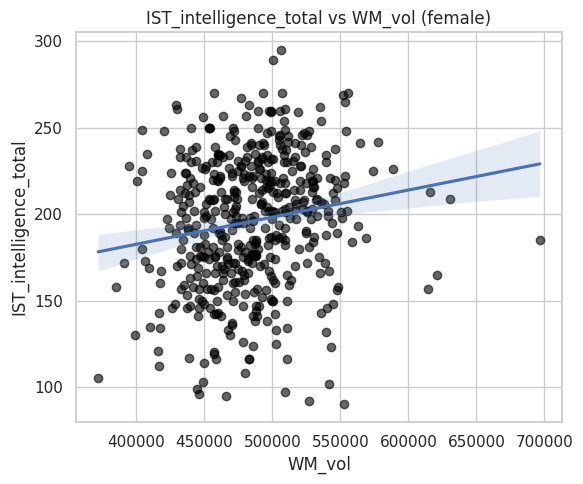

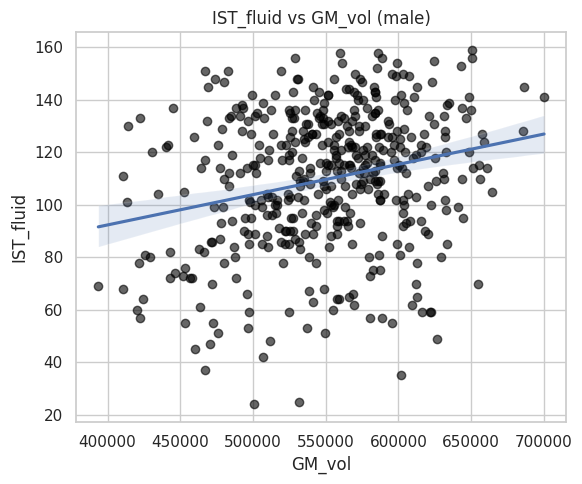

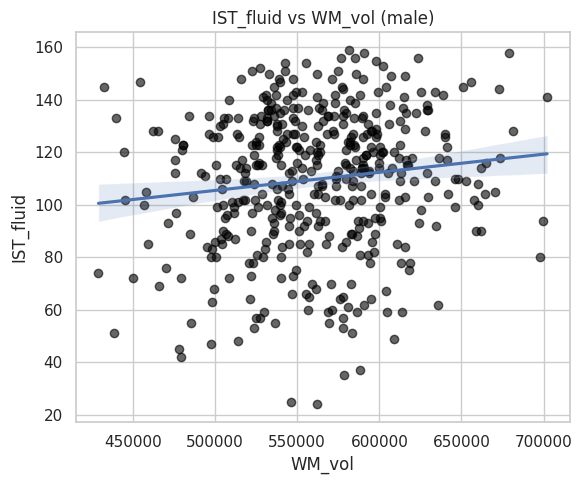

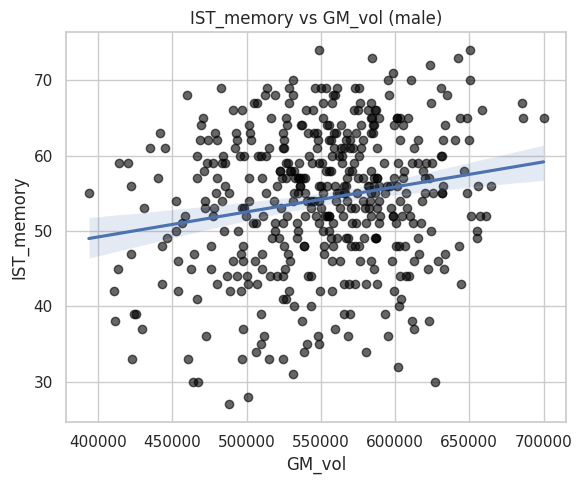

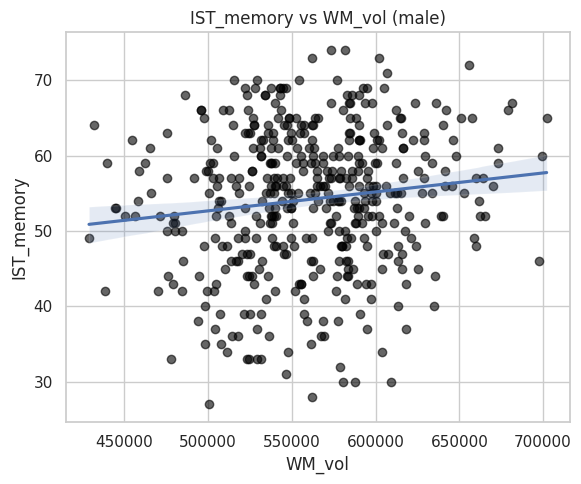

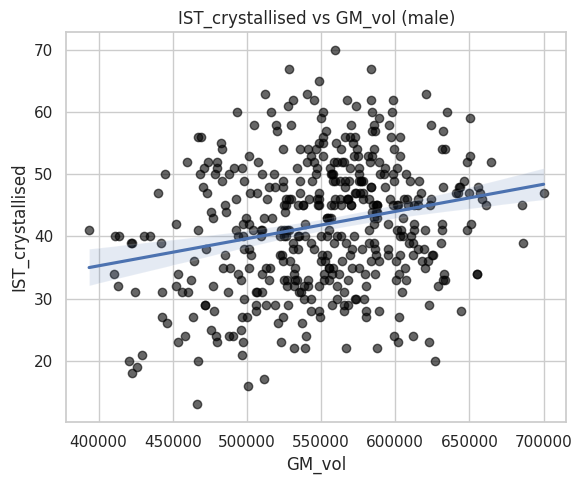

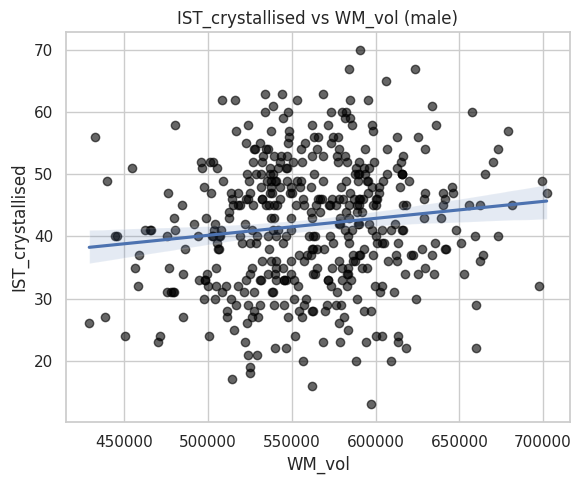

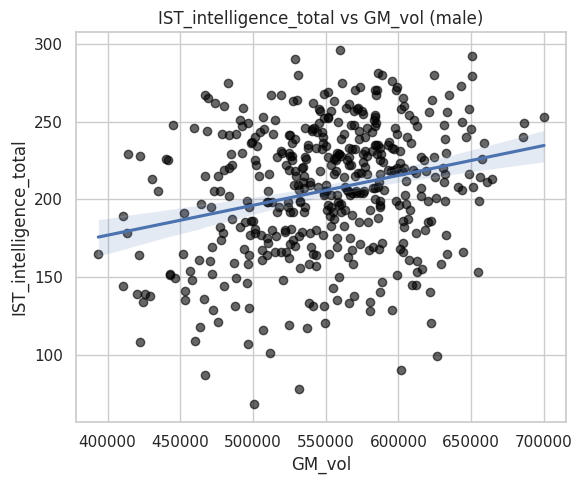

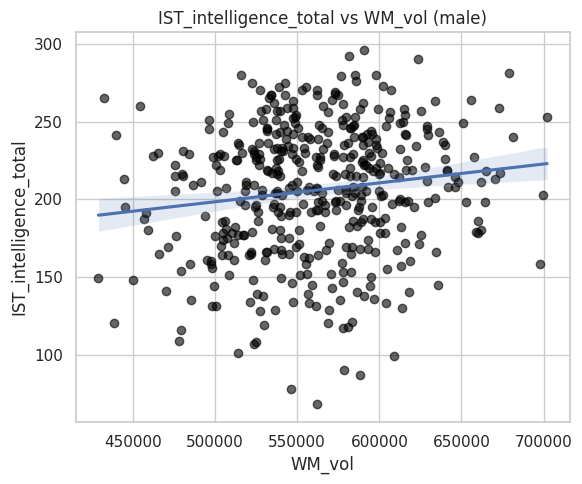

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("AOMIC_ID1000_combined.csv")

ist_cols = ['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total']

vol_cols = ['GM_vol', 'WM_vol']

sexes = df['sex'].dropna().unique()
print(f"Sexes présents dans les données : {sexes}")

sns.set(style="whitegrid")

for sex in sexes:
    df_sex = df[df['sex'] == sex]

    for ist in ist_cols:
        for vol in vol_cols:
            plt.figure(figsize=(6,5))
            sns.regplot(data=df_sex, x=vol, y=ist, scatter_kws={'alpha':0.6, 'color':'black'})
            plt.title(f"{ist} vs {vol} ({sex})")
            plt.xlabel(vol)
            plt.ylabel(ist)
            plt.tight_layout()
            plt.show()


In [ ]:
!pip uninstall numpy scipy statsmodels pygam -y
!pip install numpy scipy statsmodels pygam

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
Found existing installation: statsmodels 0.14.4
Uninstalling statsmodels-0.14.4:
  Successfully uninstalled statsmodels-0.14.4
Found existing installation: pygam 0.9.1
Uninstalling pygam-0.9.1:
  Successfully uninstalled pygam-0.9.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 55.1 MB/s eta 0:00:00
Using cached pygam-0.9.1-py3-none-any.wh

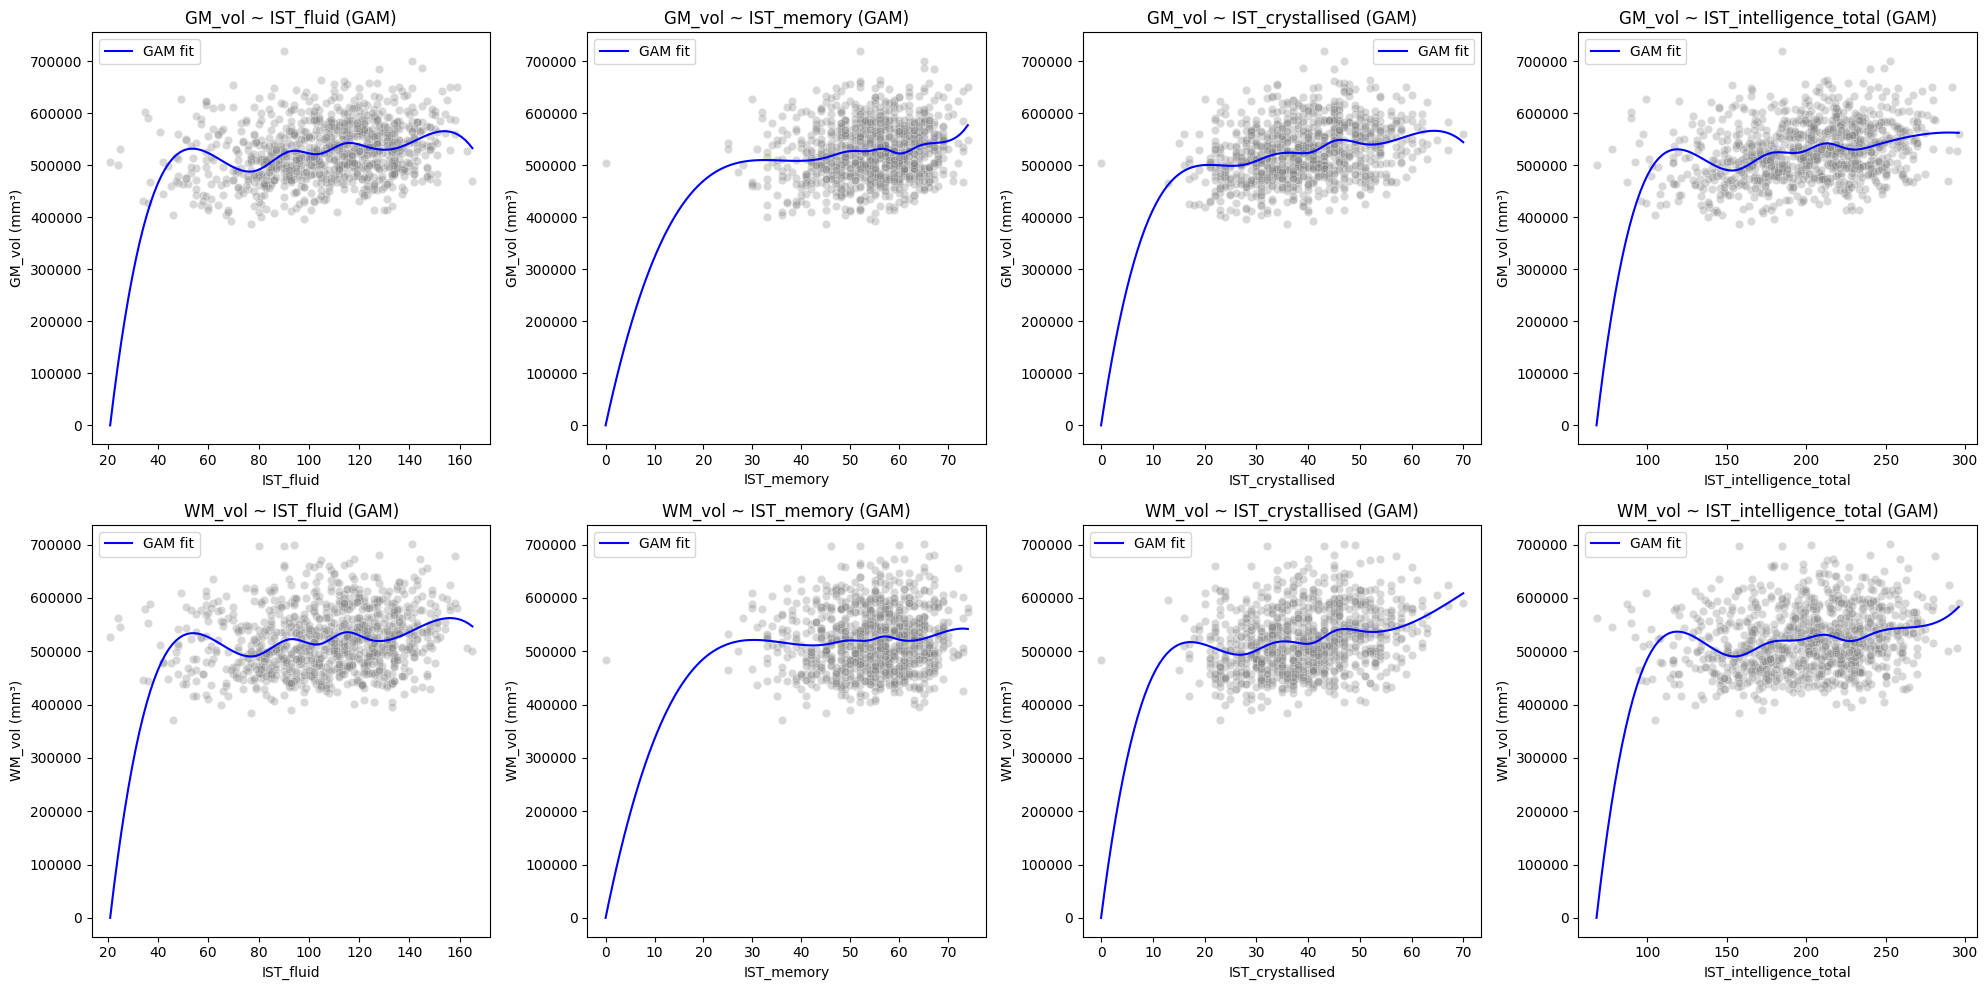

GM_vol ~ IST_fluid : Deviance Explained = -0.154
GM_vol ~ IST_memory : Deviance Explained = -0.059
GM_vol ~ IST_crystallised : Deviance Explained = 0.006
GM_vol ~ IST_intelligence_total : Deviance Explained = -0.100
WM_vol ~ IST_fluid : Deviance Explained = -0.184
WM_vol ~ IST_memory : Deviance Explained = -0.064
WM_vol ~ IST_crystallised : Deviance Explained = 0.004
WM_vol ~ IST_intelligence_total : Deviance Explained = -0.131


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

df = pd.read_csv("AOMIC_ID1000_combined.csv")

x_vars = ['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total']
y_vars = ['GM_vol', 'WM_vol']

df_spline = 10
degree = 3

results_summary = []

plt.figure(figsize=(20, 10))
plot_num = 1

for y_var in y_vars:
    for x_var in x_vars:
        sub_df = df[[x_var, y_var]].dropna()
        X = sub_df[[x_var]]
        y = sub_df[y_var]

        bs = BSplines(X, df=[df_spline], degree=[degree])

        gam = GLMGam(y, smoother=bs)
        res = gam.fit()

        x_pred = np.linspace(X[x_var].min(), X[x_var].max(), 100)
        X_pred = pd.DataFrame({x_var: x_pred})


        X_pred_transformed = bs.transform(X_pred.values)


        y_pred = res.predict(X_pred_transformed)

        plt.subplot(len(y_vars), len(x_vars), plot_num)
        sns.scatterplot(x=X[x_var], y=y, alpha=0.3, color="grey")
        plt.plot(x_pred, y_pred, color='blue', label='GAM fit')
        plt.xlabel(x_var)
        plt.ylabel(y_var + " (mm³)")
        plt.title(f'{y_var} ~ {x_var} (GAM)')
        plt.legend()

        dev_exp = 1 - res.deviance / res.null_deviance
        results_summary.append(f'{y_var} ~ {x_var} : Deviance Explained = {dev_exp:.3f}')

        plot_num += 1

plt.tight_layout()
plt.show()

for line in results_summary:
    print(line)

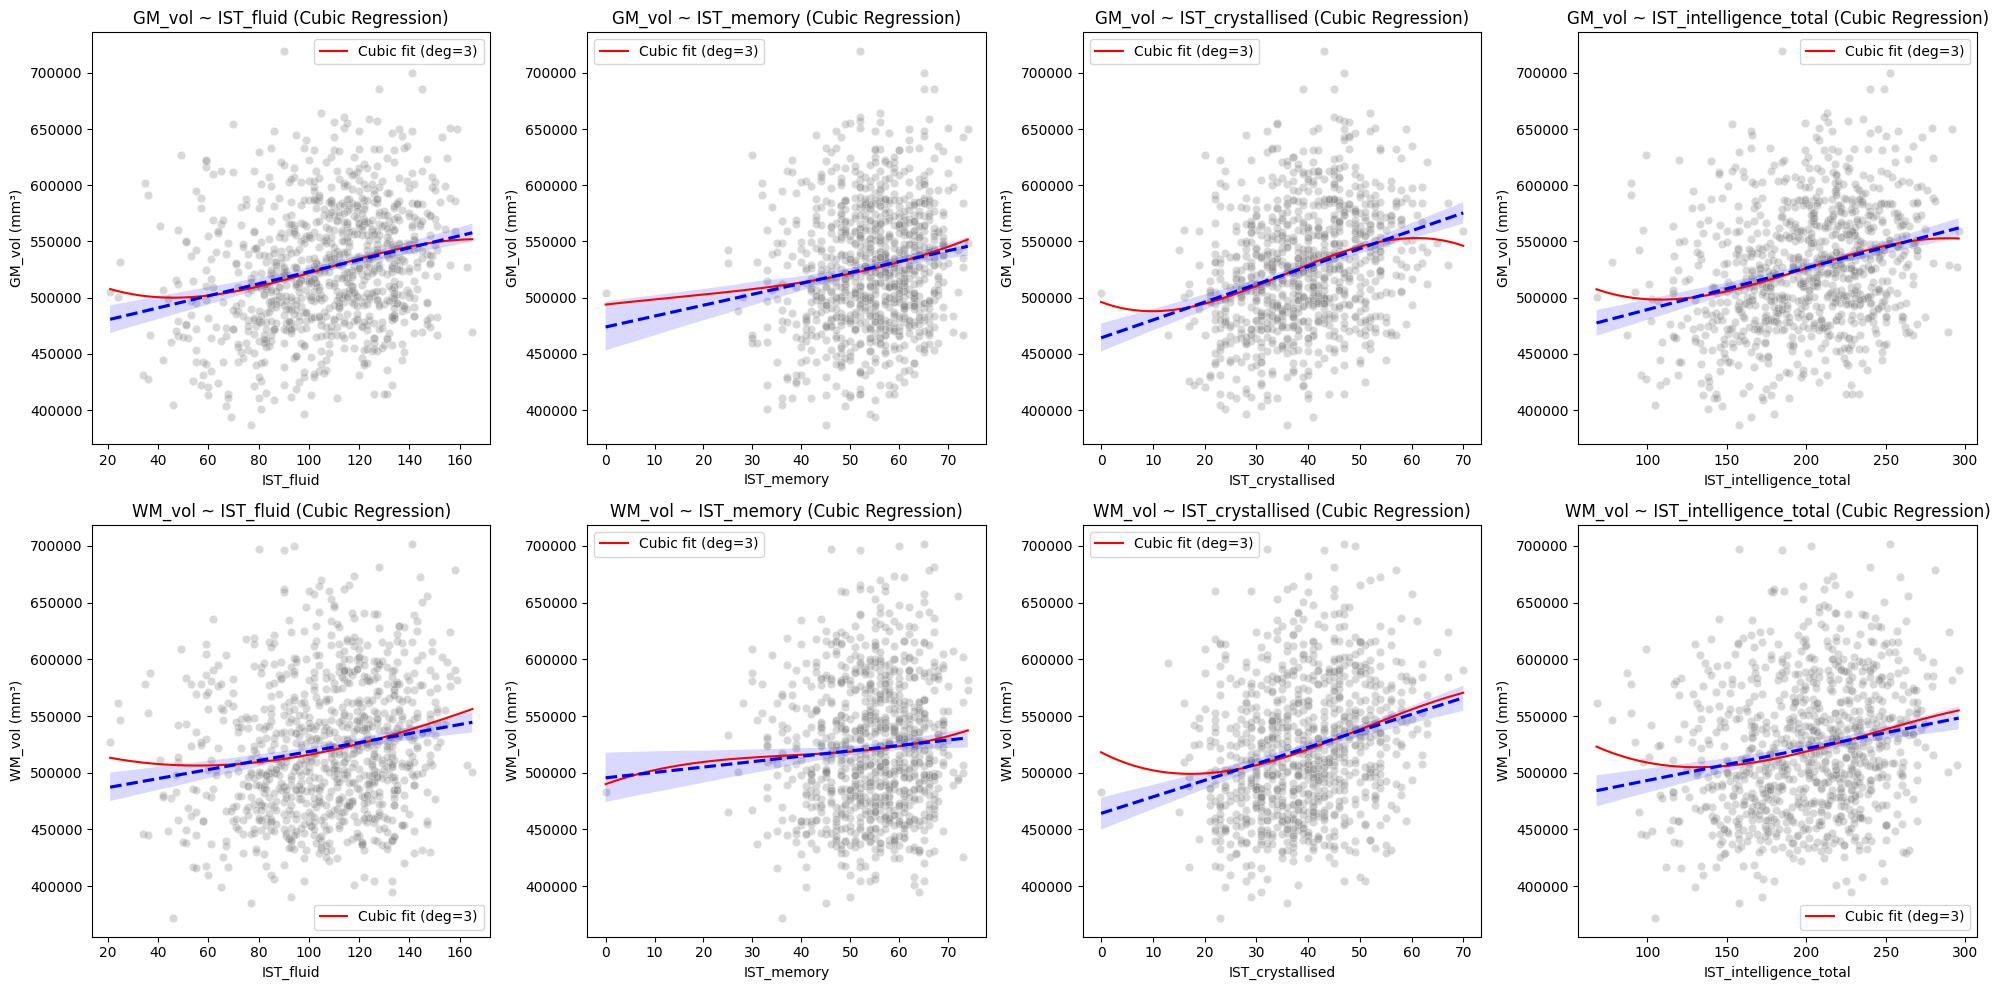

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("AOMIC_ID1000_combined.csv")

x_vars = ['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total']
y_vars = ['GM_vol', 'WM_vol']

plt.figure(figsize=(20, 10))
plot_num = 1

for y_var in y_vars:
    for x_var in x_vars:
        sub_df = df[[x_var, y_var]].dropna()
        X = sub_df[x_var]
        y = sub_df[y_var]

        if len(sub_df) >= 4:
            coeffs = np.polyfit(X, y, deg=3)

            x_plot = np.linspace(X.min(), X.max(), 200)
            y_plot = np.polyval(coeffs, x_plot)

            plt.subplot(len(y_vars), len(x_vars), plot_num)
            sns.scatterplot(x=X, y=y, alpha=0.3, color="grey")
            plt.plot(x_plot, y_plot, color='red', label='Cubic fit (deg=3)')

            sns.regplot(x=X, y=y, scatter=False, ax=plt.gca(),
                        line_kws={'color': 'blue', 'linestyle': '--', 'label': 'Linear fit'})

            plt.xlabel(x_var)
            plt.ylabel(y_var + " (mm³)")
            plt.title(f'{y_var} ~ {x_var} (Cubic Regression)')
            plt.legend()

        else:
            plt.subplot(len(y_vars), len(x_vars), plot_num)
            sns.scatterplot(x=X, y=y, alpha=0.3, color="grey")
            plt.title(f'{y_var} ~ {x_var} (Not enough data for Cubic fit)')
            plt.xlabel(x_var)
            plt.ylabel(y_var + " (mm³)")


        plot_num += 1

plt.tight_layout()
plt.show()

Sexes présents dans les données : ['female' 'male']


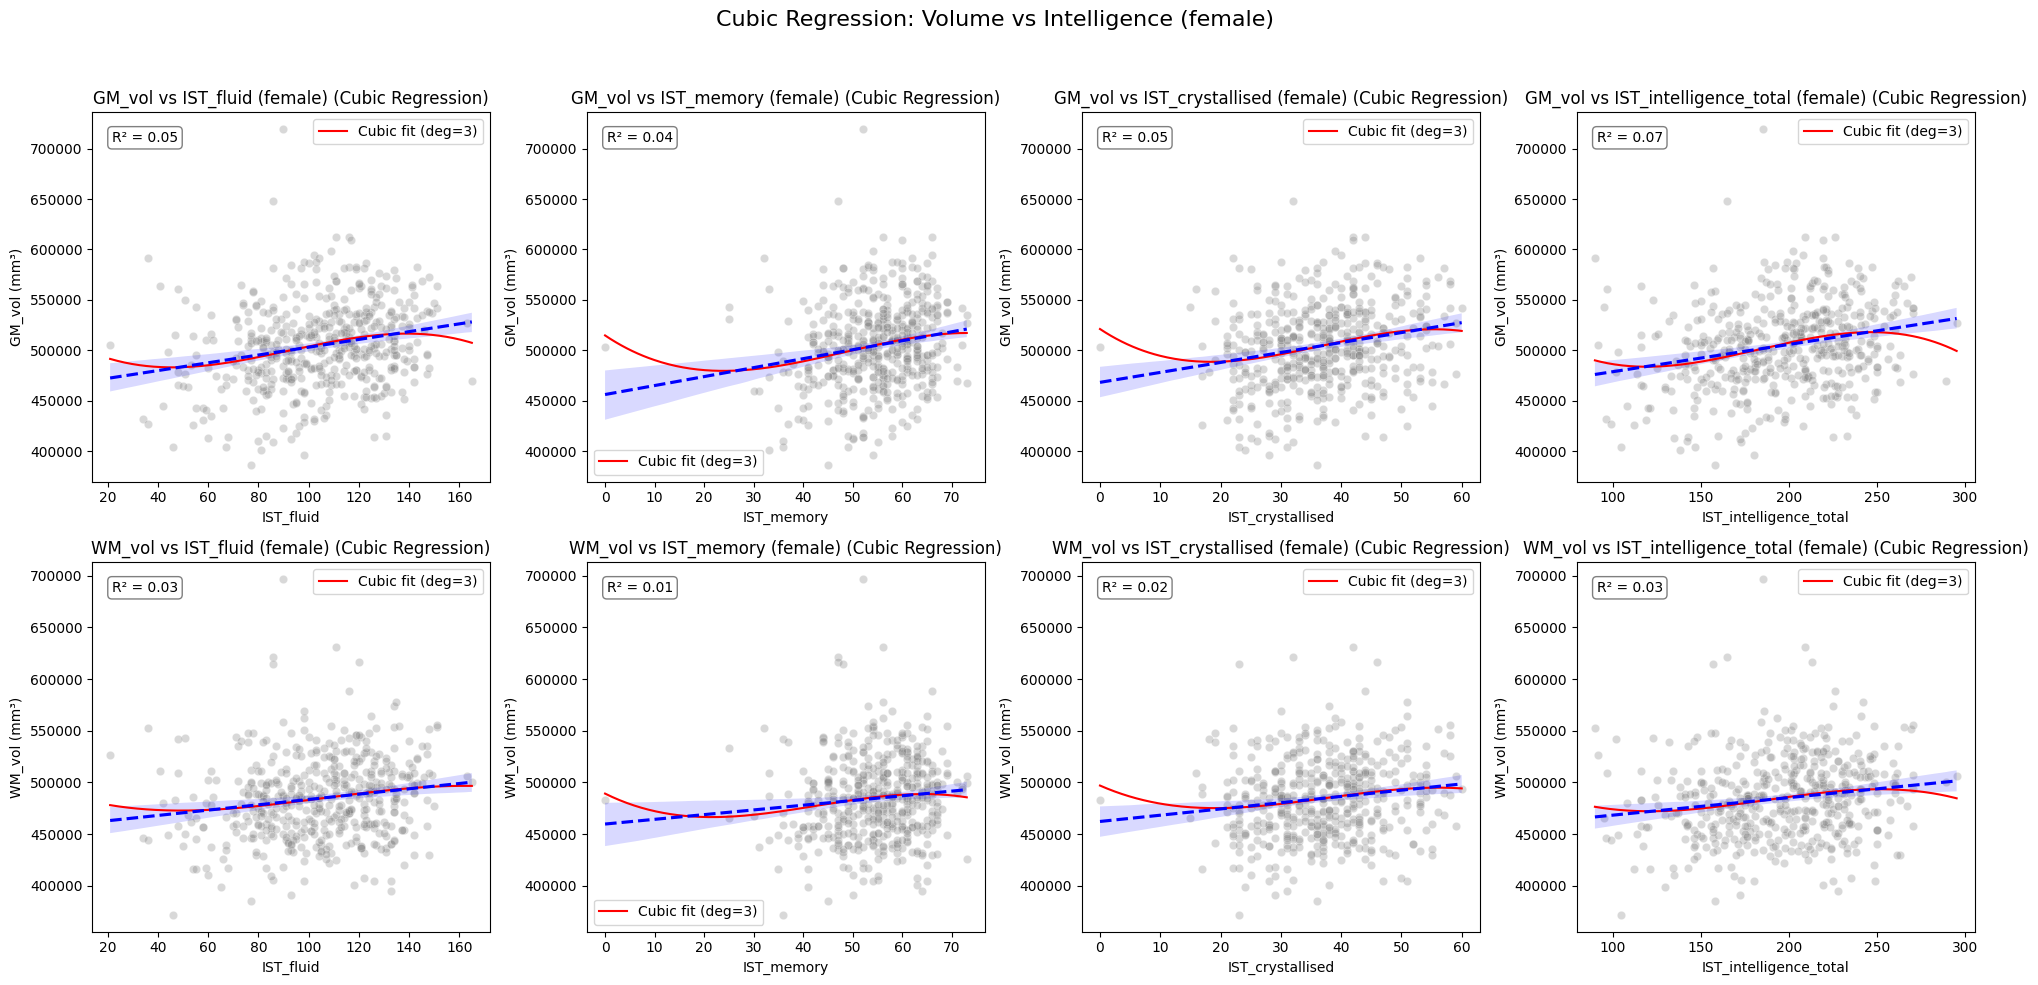

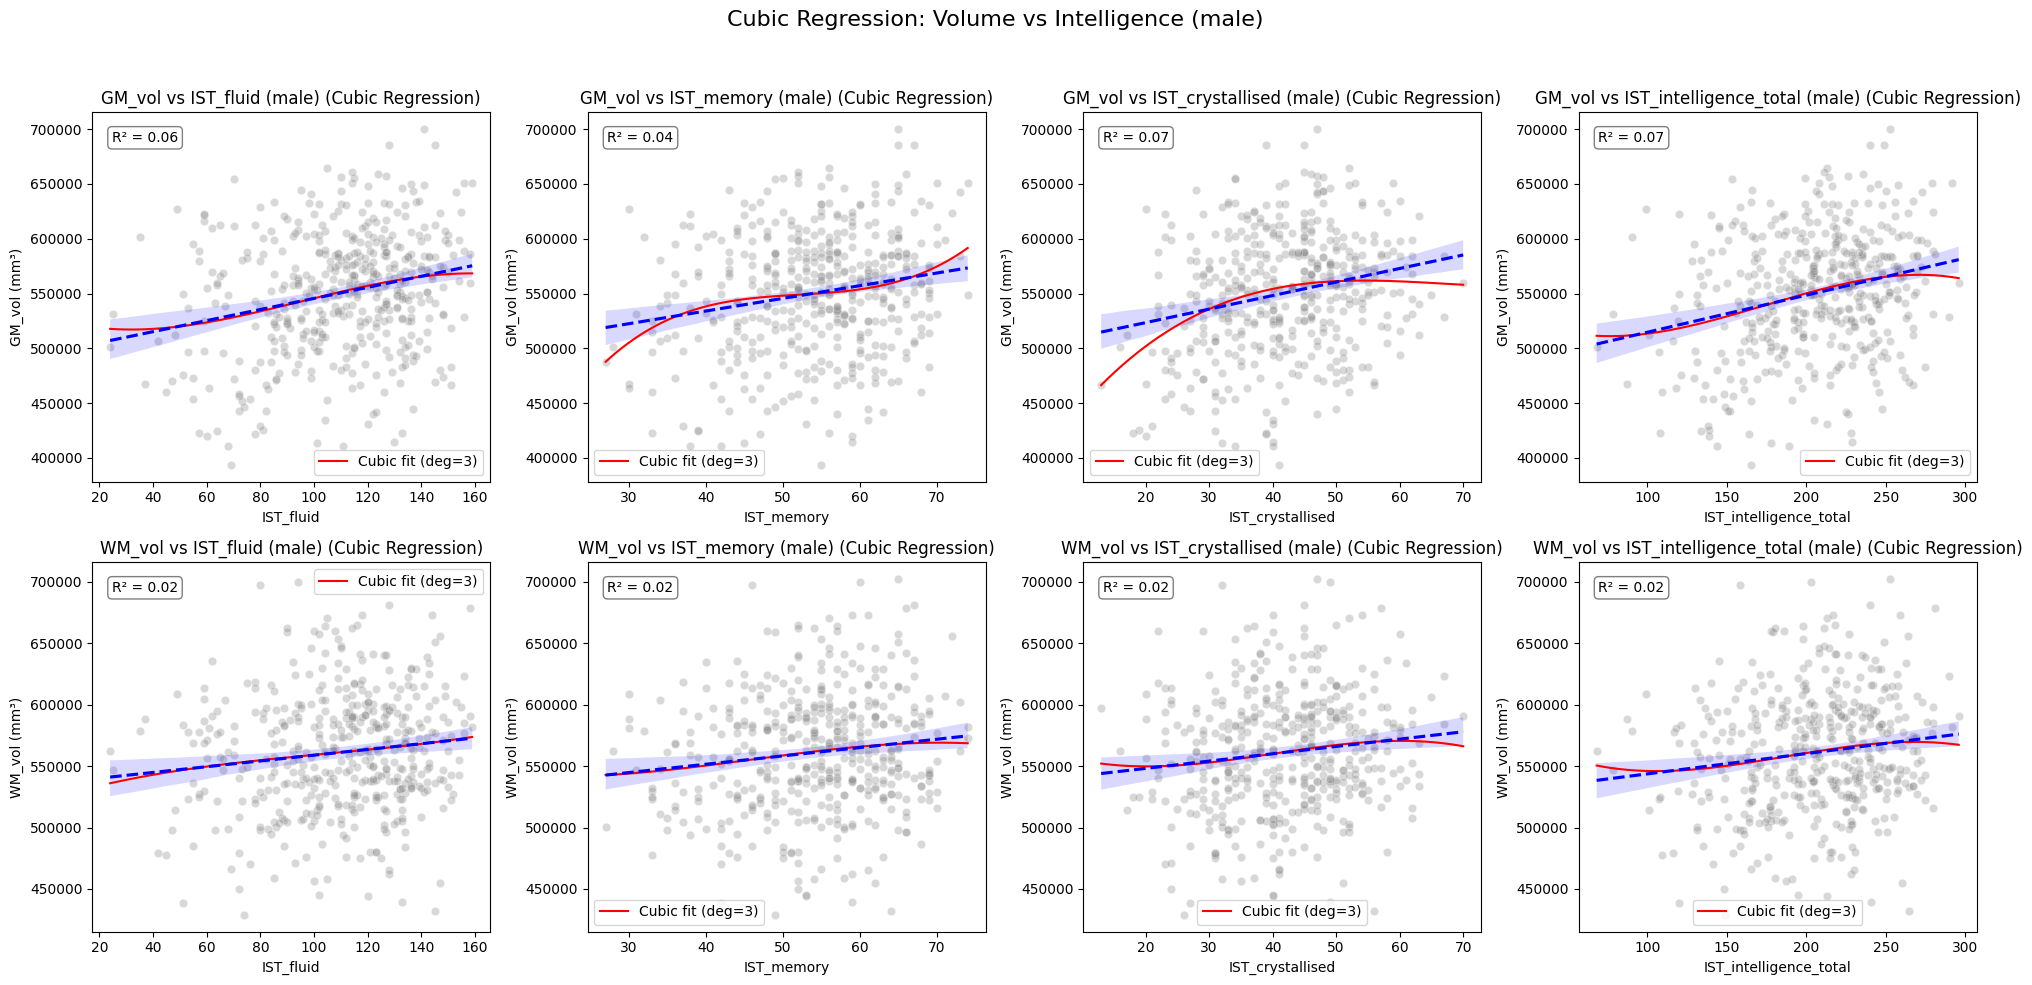

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("AOMIC_ID1000_combined.csv")

x_vars = ['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total']
y_vars = ['GM_vol', 'WM_vol']

sexes = df['sex'].dropna().unique()

for sex in sexes:
    df_sex = df[df['sex'] == sex]

    fig, axs = plt.subplots(len(y_vars), len(x_vars), figsize=(20, 10), squeeze=False)

    for i, y_var in enumerate(y_vars):
        for j, x_var in enumerate(x_vars):
            ax = axs[i, j]

            sub_df = df_sex[[x_var, y_var]].dropna()
            X = sub_df[x_var]
            y = sub_df[y_var]

            if len(sub_df) >= 4:
                coeffs = np.polyfit(X, y, deg=3)
                y_pred = np.polyval(coeffs, X)
                ss_res = np.sum((y - y_pred) ** 2)
                ss_tot = np.sum((y - np.mean(y)) ** 2)
                r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan

                sns.scatterplot(x=X, y=y, alpha=0.3, color="grey", ax=ax)
                x_plot = np.linspace(X.min(), X.max(), 200)
                y_plot = np.polyval(coeffs, x_plot)
                ax.plot(x_plot, y_plot, color='red', label='Cubic fit (deg=3)')

                sns.regplot(x=X, y=y, scatter=False, ax=ax,
                            line_kws={'color': 'blue', 'linestyle': '--', 'label': 'Linear fit'})

                r2_text = f'R² = {r2:.2f}'
                ax.text(0.05, 0.95, r2_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

                ax.set_title(f'{y_var} vs {x_var} ({sex}) (Cubic Regression)')
                ax.set_xlabel(x_var)
                ax.set_ylabel(y_var + " (mm³)")
                ax.legend()

            else:
                sns.scatterplot(x=X, y=y, alpha=0.3, color="grey", ax=ax)
                ax.set_title(f'{y_var} vs {x_var} ({sex}) (Not enough data for Cubic fit)')
                ax.set_xlabel(x_var)
                ax.set_ylabel(y_var + " (mm³)")

    fig.suptitle(f'Cubic Regression: Volume vs Intelligence ({sex})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
data.colum

Sexes présents dans les données : ['female' 'male']


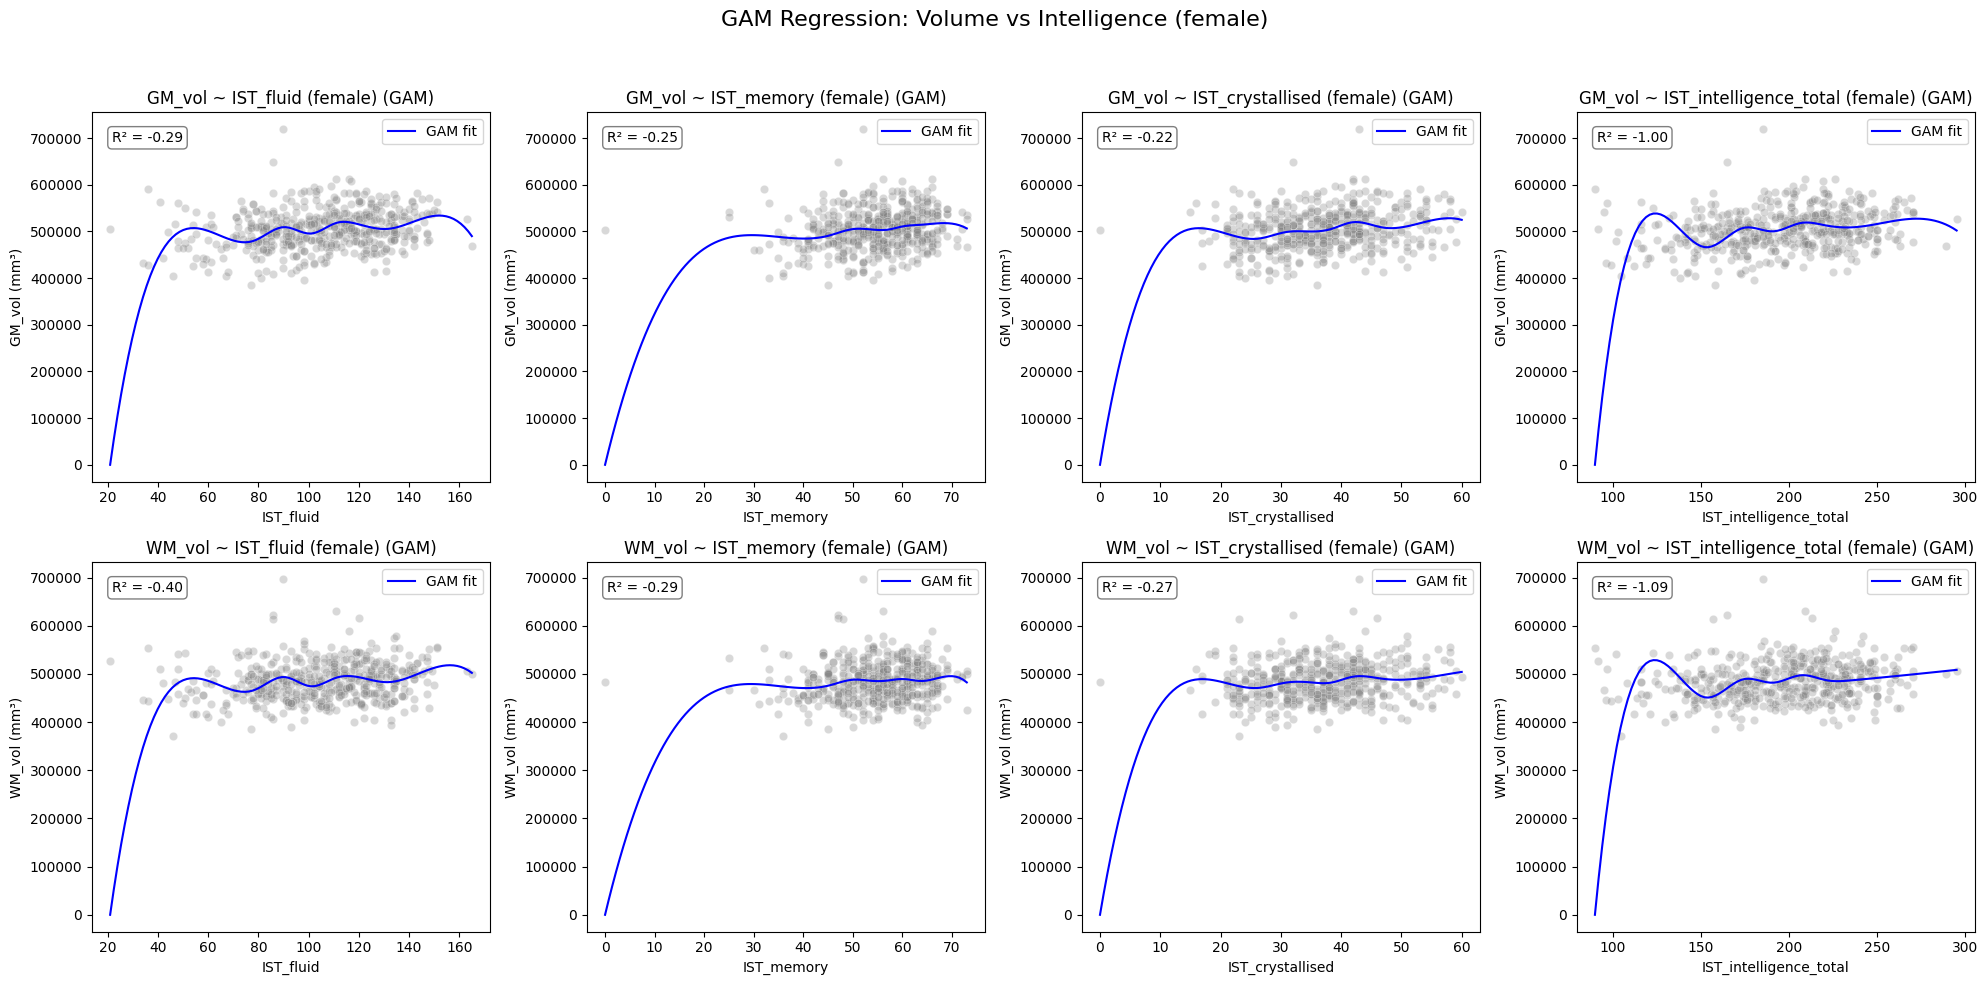


--- GAM Regression Summary for female ---
GM_vol ~ IST_fluid (female): Deviance Explained = -0.285
GM_vol ~ IST_memory (female): Deviance Explained = -0.248
GM_vol ~ IST_crystallised (female): Deviance Explained = -0.219
GM_vol ~ IST_intelligence_total (female): Deviance Explained = -0.997
WM_vol ~ IST_fluid (female): Deviance Explained = -0.402
WM_vol ~ IST_memory (female): Deviance Explained = -0.289
WM_vol ~ IST_crystallised (female): Deviance Explained = -0.270
WM_vol ~ IST_intelligence_total (female): Deviance Explained = -1.090
-----------------------------------------


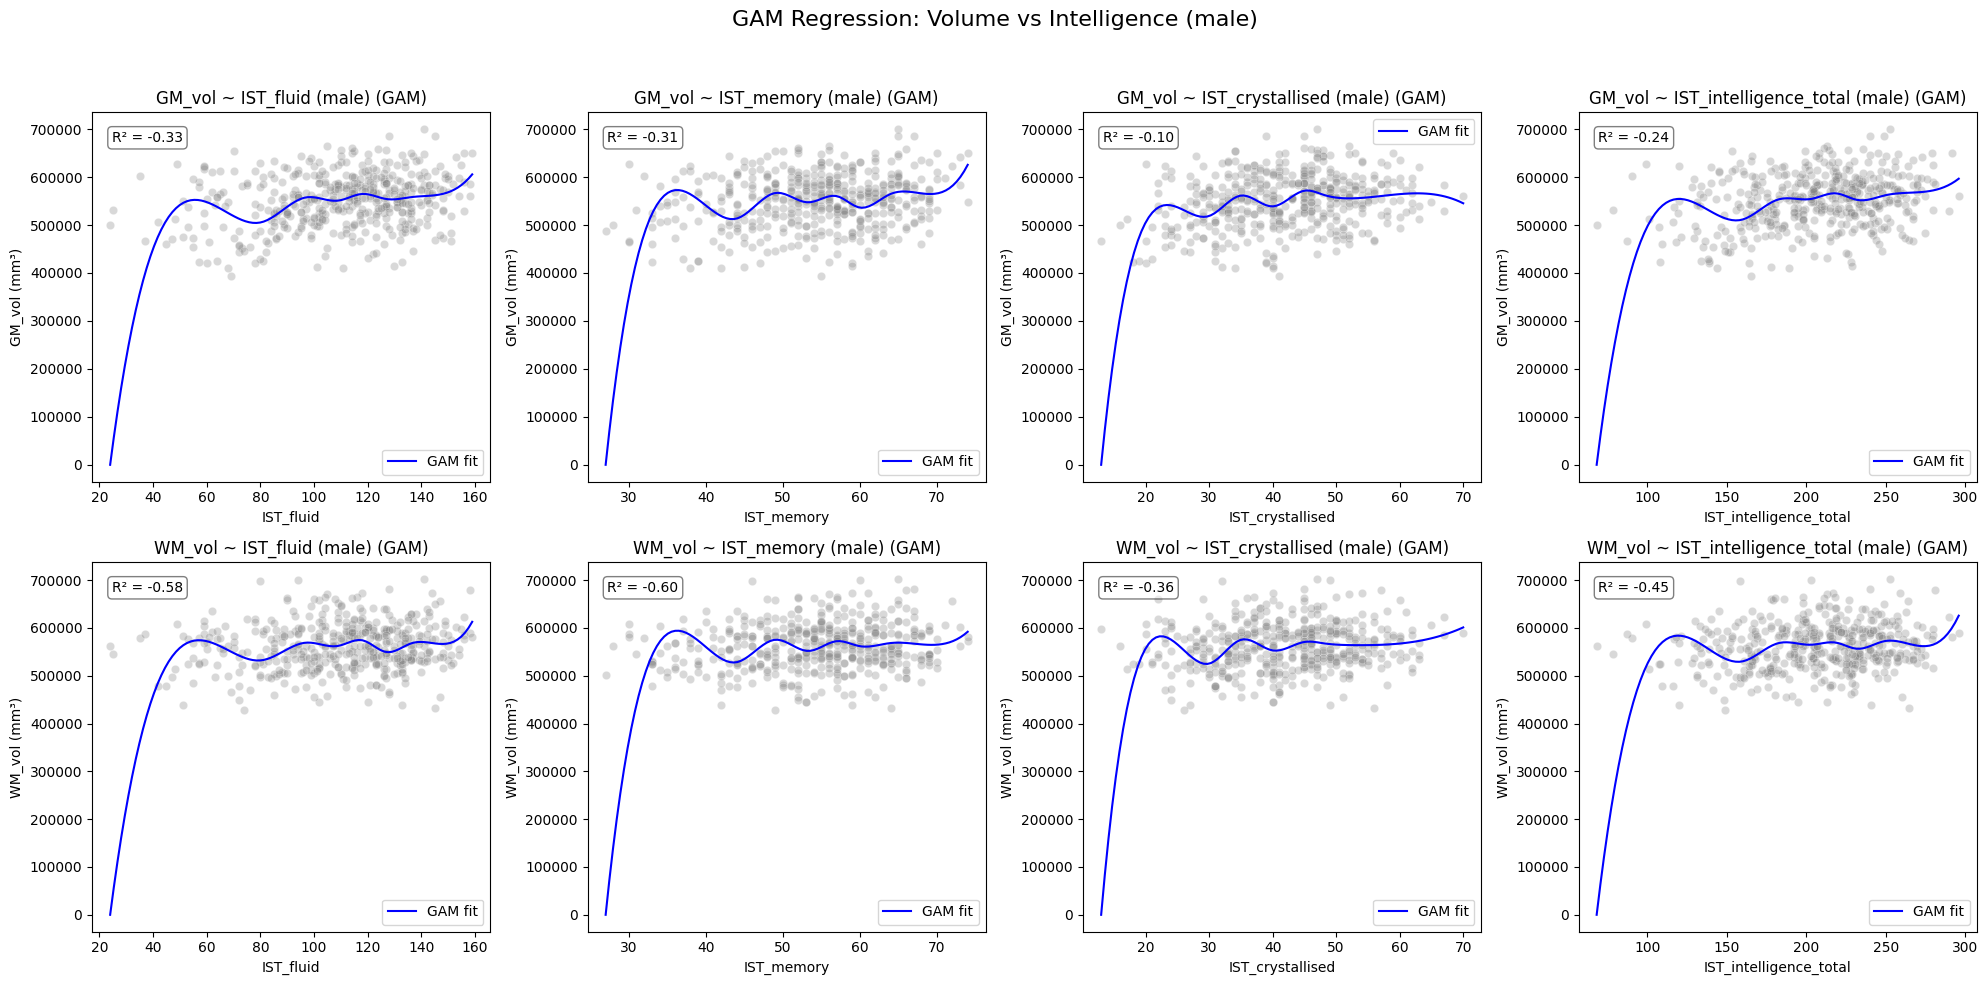


--- GAM Regression Summary for male ---
GM_vol ~ IST_fluid (male): Deviance Explained = -0.329
GM_vol ~ IST_memory (male): Deviance Explained = -0.312
GM_vol ~ IST_crystallised (male): Deviance Explained = -0.102
GM_vol ~ IST_intelligence_total (male): Deviance Explained = -0.238
WM_vol ~ IST_fluid (male): Deviance Explained = -0.578
WM_vol ~ IST_memory (male): Deviance Explained = -0.604
WM_vol ~ IST_crystallised (male): Deviance Explained = -0.362
WM_vol ~ IST_intelligence_total (male): Deviance Explained = -0.446
---------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

df = pd.read_csv("AOMIC_ID1000_combined.csv")

x_vars = ['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total']
y_vars = ['GM_vol', 'WM_vol']

df_spline = 10
degree = 3

sexes = df['sex'].dropna().unique()
print(f"Sexes présents dans les données : {sexes}")

for sex in sexes:
    df_sex = df[df['sex'] == sex]

    results_summary = []

    fig, axs = plt.subplots(len(y_vars), len(x_vars), figsize=(20, 10), squeeze=False)

    for i, y_var in enumerate(y_vars):
        for j, x_var in enumerate(x_vars):
            ax = axs[i, j]

            sub_df = df_sex[[x_var, y_var]].dropna()

            if len(sub_df) > df_spline:
                X = sub_df[[x_var]]
                y = sub_df[y_var]

                bs = BSplines(X, df=[df_spline], degree=[degree])

                gam = GLMGam(y, smoother=bs)
                res = gam.fit()

                x_pred = np.linspace(X[x_var].min(), X[x_var].max(), 100)
                X_pred = pd.DataFrame({x_var: x_pred})

                X_pred_transformed = bs.transform(X_pred.values)

                y_pred = res.predict(X_pred_transformed)

                sns.scatterplot(x=X[x_var], y=y, alpha=0.3, color="grey", ax=ax)
                ax.plot(x_pred, y_pred, color='blue', label='GAM fit')
                ax.set_xlabel(x_var)
                ax.set_ylabel(y_var + " (mm³)")

                dev_exp = 1 - res.deviance / res.null_deviance if res.null_deviance != 0 else np.nan
                r2_text = f'R² = {dev_exp:.2f}'
                results_summary.append(f'{y_var} ~ {x_var} ({sex}): Deviance Explained = {dev_exp:.3f}')

                ax.text(0.05, 0.95, r2_text, transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

                ax.set_title(f'{y_var} ~ {x_var} ({sex}) (GAM)')
                ax.legend()

            else:
                sns.scatterplot(data=sub_df, x=x_var, y=y_var, alpha=0.3, color="grey", ax=ax)
                ax.set_title(f'{y_var} ~ {x_var} ({sex}) (Not enough data for GAM)')
                ax.set_xlabel(x_var)
                ax.set_ylabel(y_var + " (mm³)")

    fig.suptitle(f'GAM Regression: Volume vs Intelligence ({sex})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"\n GAM Regression Summary for {sex} ")
    for line in results_summary:
        print(line)
    print("-" * (len(f "GAM Regression Summary for {sex} ")))


Sexes présents dans les données : ['female' 'male']


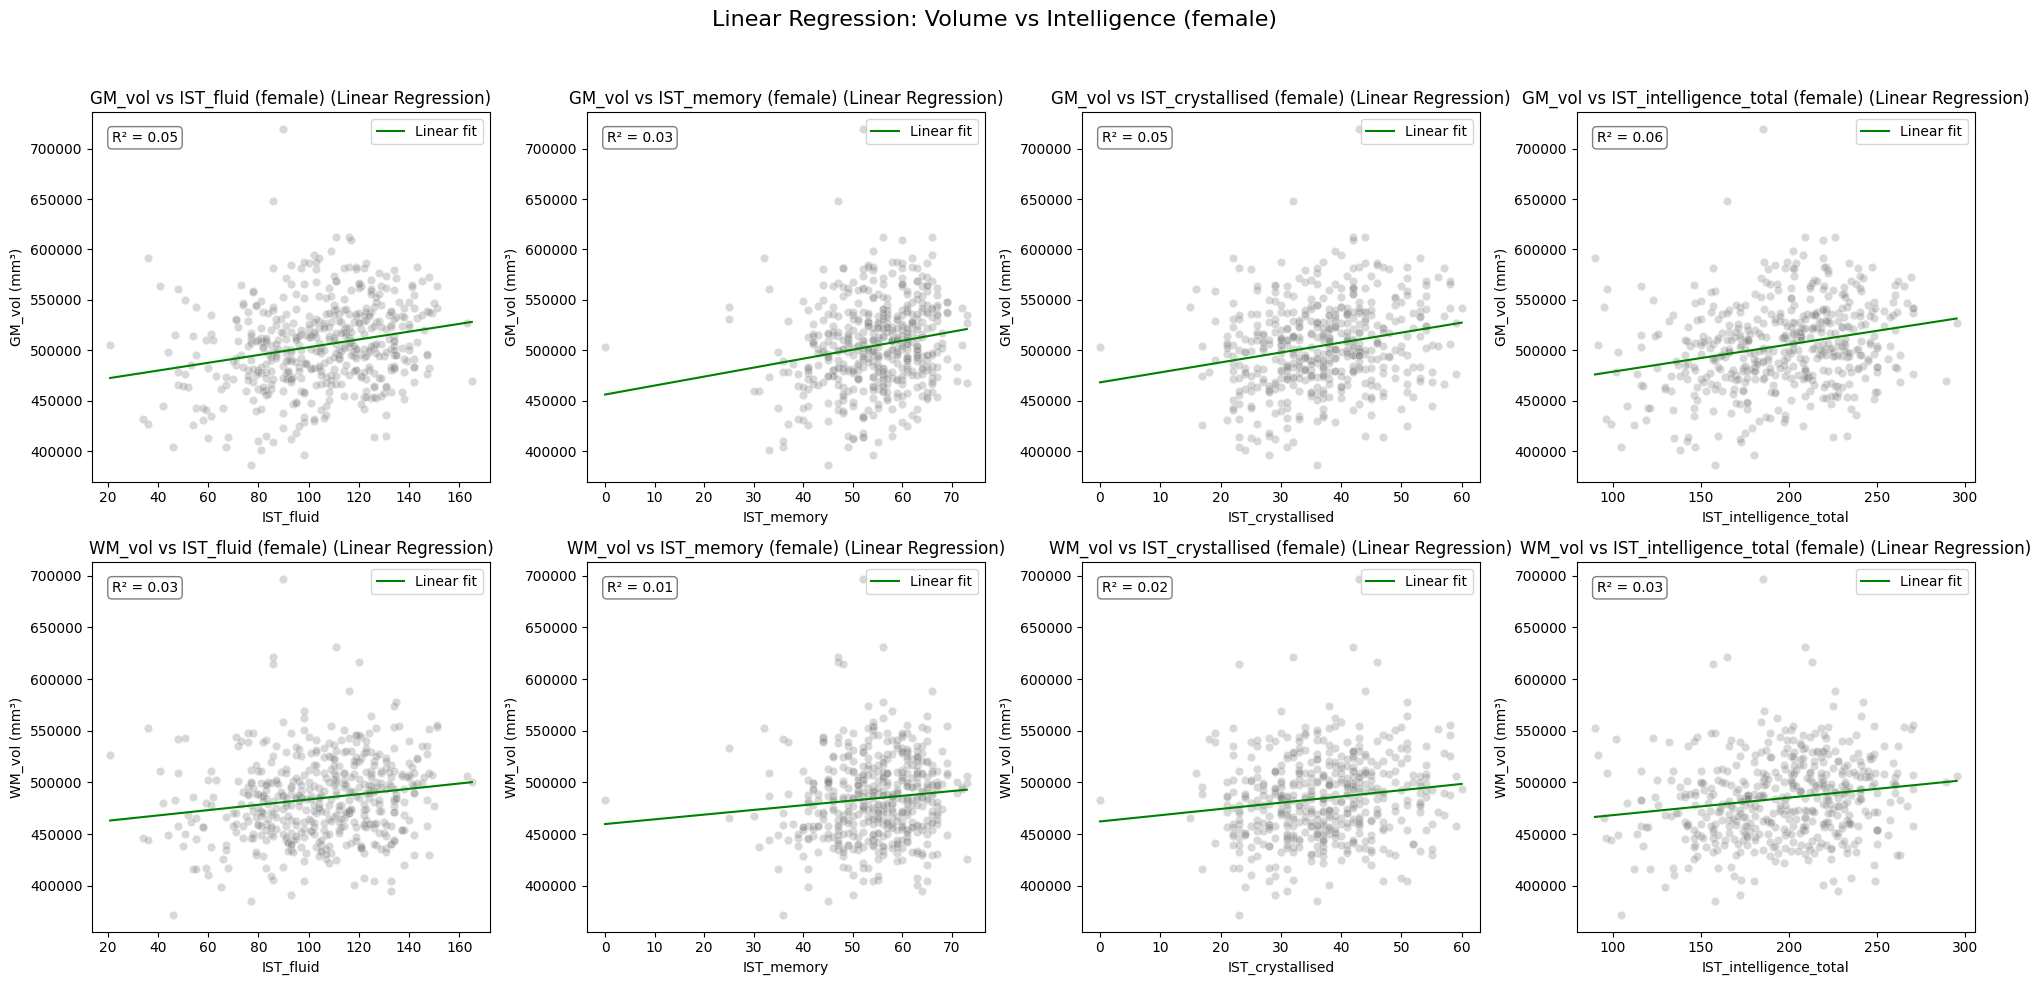

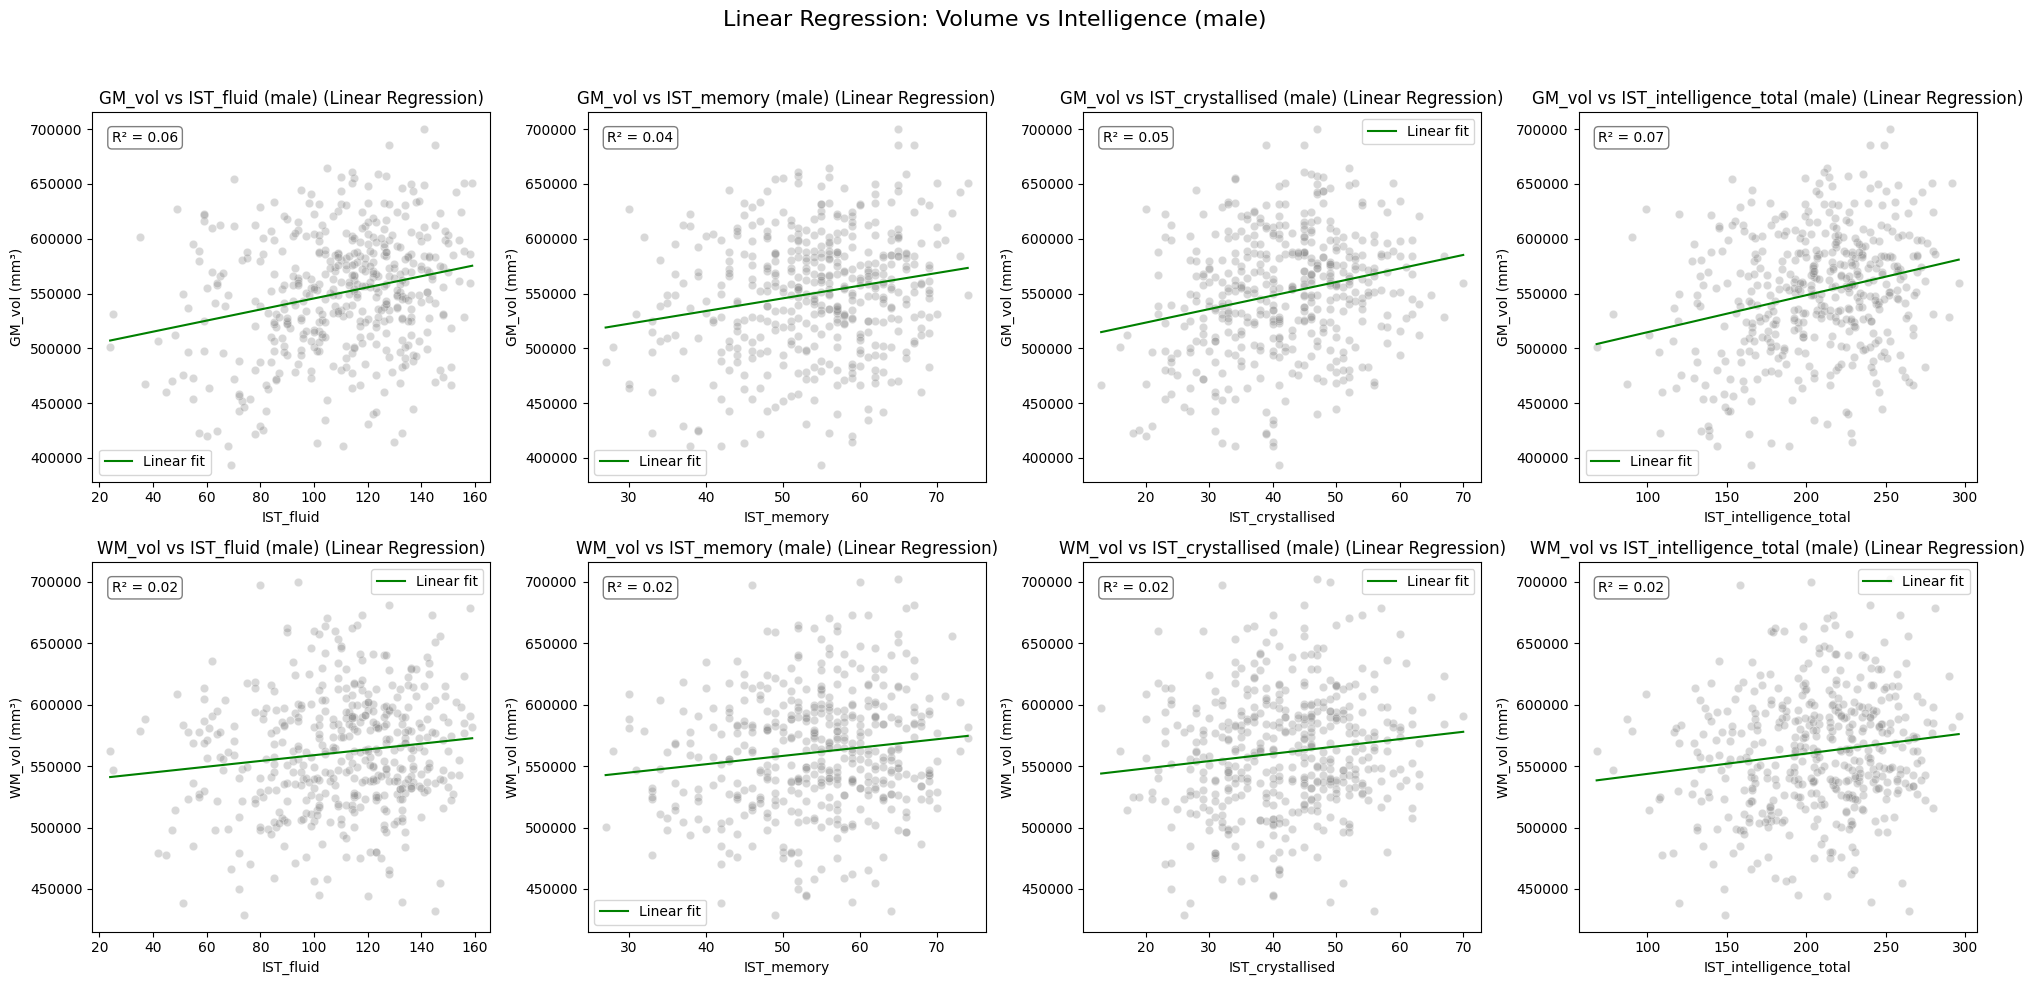

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("AOMIC_ID1000_combined.csv")

x_vars = ['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total']
y_vars = ['GM_vol', 'WM_vol']

sexes = df['sex'].dropna().unique()
print(f"Sexes présents dans les données : {sexes}")

for sex in sexes:
    df_sex = df[df['sex'] == sex]

    fig, axs = plt.subplots(len(y_vars), len(x_vars), figsize=(20, 10), squeeze=False)

    for i, y_var in enumerate(y_vars):
        for j, x_var in enumerate(x_vars):
            ax = axs[i, j]
            sub_df = df_sex[[x_var, y_var]].dropna()
            X = sub_df[x_var]
            y = sub_df[y_var]

            if len(sub_df) >= 2:
                coeffs = np.polyfit(X, y, deg=1)
                y_pred = np.polyval(coeffs, X)

                ss_res = np.sum((y - y_pred) ** 2)
                ss_tot = np.sum((y - np.mean(y)) ** 2)
                r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

                sns.scatterplot(x=X, y=y, alpha=0.3, color="grey", ax=ax)
                x_plot = np.linspace(X.min(), X.max(), 200)
                y_plot = np.polyval(coeffs, x_plot)
                ax.plot(x_plot, y_plot, color='green', label='Linear fit')

                ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))

                ax.set_title(f'{y_var} vs {x_var} ({sex}) (Linear Regression)')
                ax.set_xlabel(x_var)
                ax.set_ylabel(y_var + " (mm³)")
                ax.legend()

            else:
                sns.scatterplot(x=X, y=y, alpha=0.3, color="grey", ax=ax)
                ax.set_title(f'{y_var} vs {x_var} ({sex}) (Not enough data)')
                ax.set_xlabel(x_var)
                ax.set_ylabel(y_var + " (mm³)")
                print(f"Attention ({sex}) : Pas assez de points ({len(sub_df)}) pour la régression linéaire pour {y_var} vs {x_var}.")

    fig.suptitle(f'Linear Regression: Volume vs Intelligence ({sex})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("AOMIC_ID1000_combined.csv")

y = df['IST_fluid']

exclude_vars = ['IST_memory', 'IST_crystallised', 'IST_intelligence_total', 'IST_fluid']
X = df.drop(columns=exclude_vars, errors='ignore')

X = X.select_dtypes(include=[np.number])

X = X.dropna(axis=1, thresh=int(0.8 * len(X)))

Xy = pd.concat([X, y], axis=1).dropna()
X = Xy.drop(columns=['IST_fluid'])
y = Xy['IST_fluid']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

f_scores, p_values = f_regression(X_scaled, y)

results = pd.DataFrame({
    'Variable': X.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values(by='F_score', ascending=False)

print(results.head(10))

best_var = results.iloc[0]['Variable']
print(f"\n Best predictors : {best_var}")


🔍 Top prédicteurs de IST_fluid (par régression univariée) :

           Variable    F_score       p_value
2    background_SES  96.223060  1.211123e-21
16           GM_vol  64.336807  3.276695e-15
9             NEO_O  45.748609  2.427206e-11
12           STAI_T  34.825223  5.115452e-09
17           WM_vol  28.413427  1.241280e-07
3         BAS_drive  18.283813  2.107878e-05
18  GreyWhiteMRatio   6.549991  1.065202e-02
11            NEO_C   5.021620  2.527755e-02
7             NEO_N   4.192911  4.088509e-02
1               BMI   3.877026  4.925970e-02

🏆 Meilleur prédicteur : background_SES


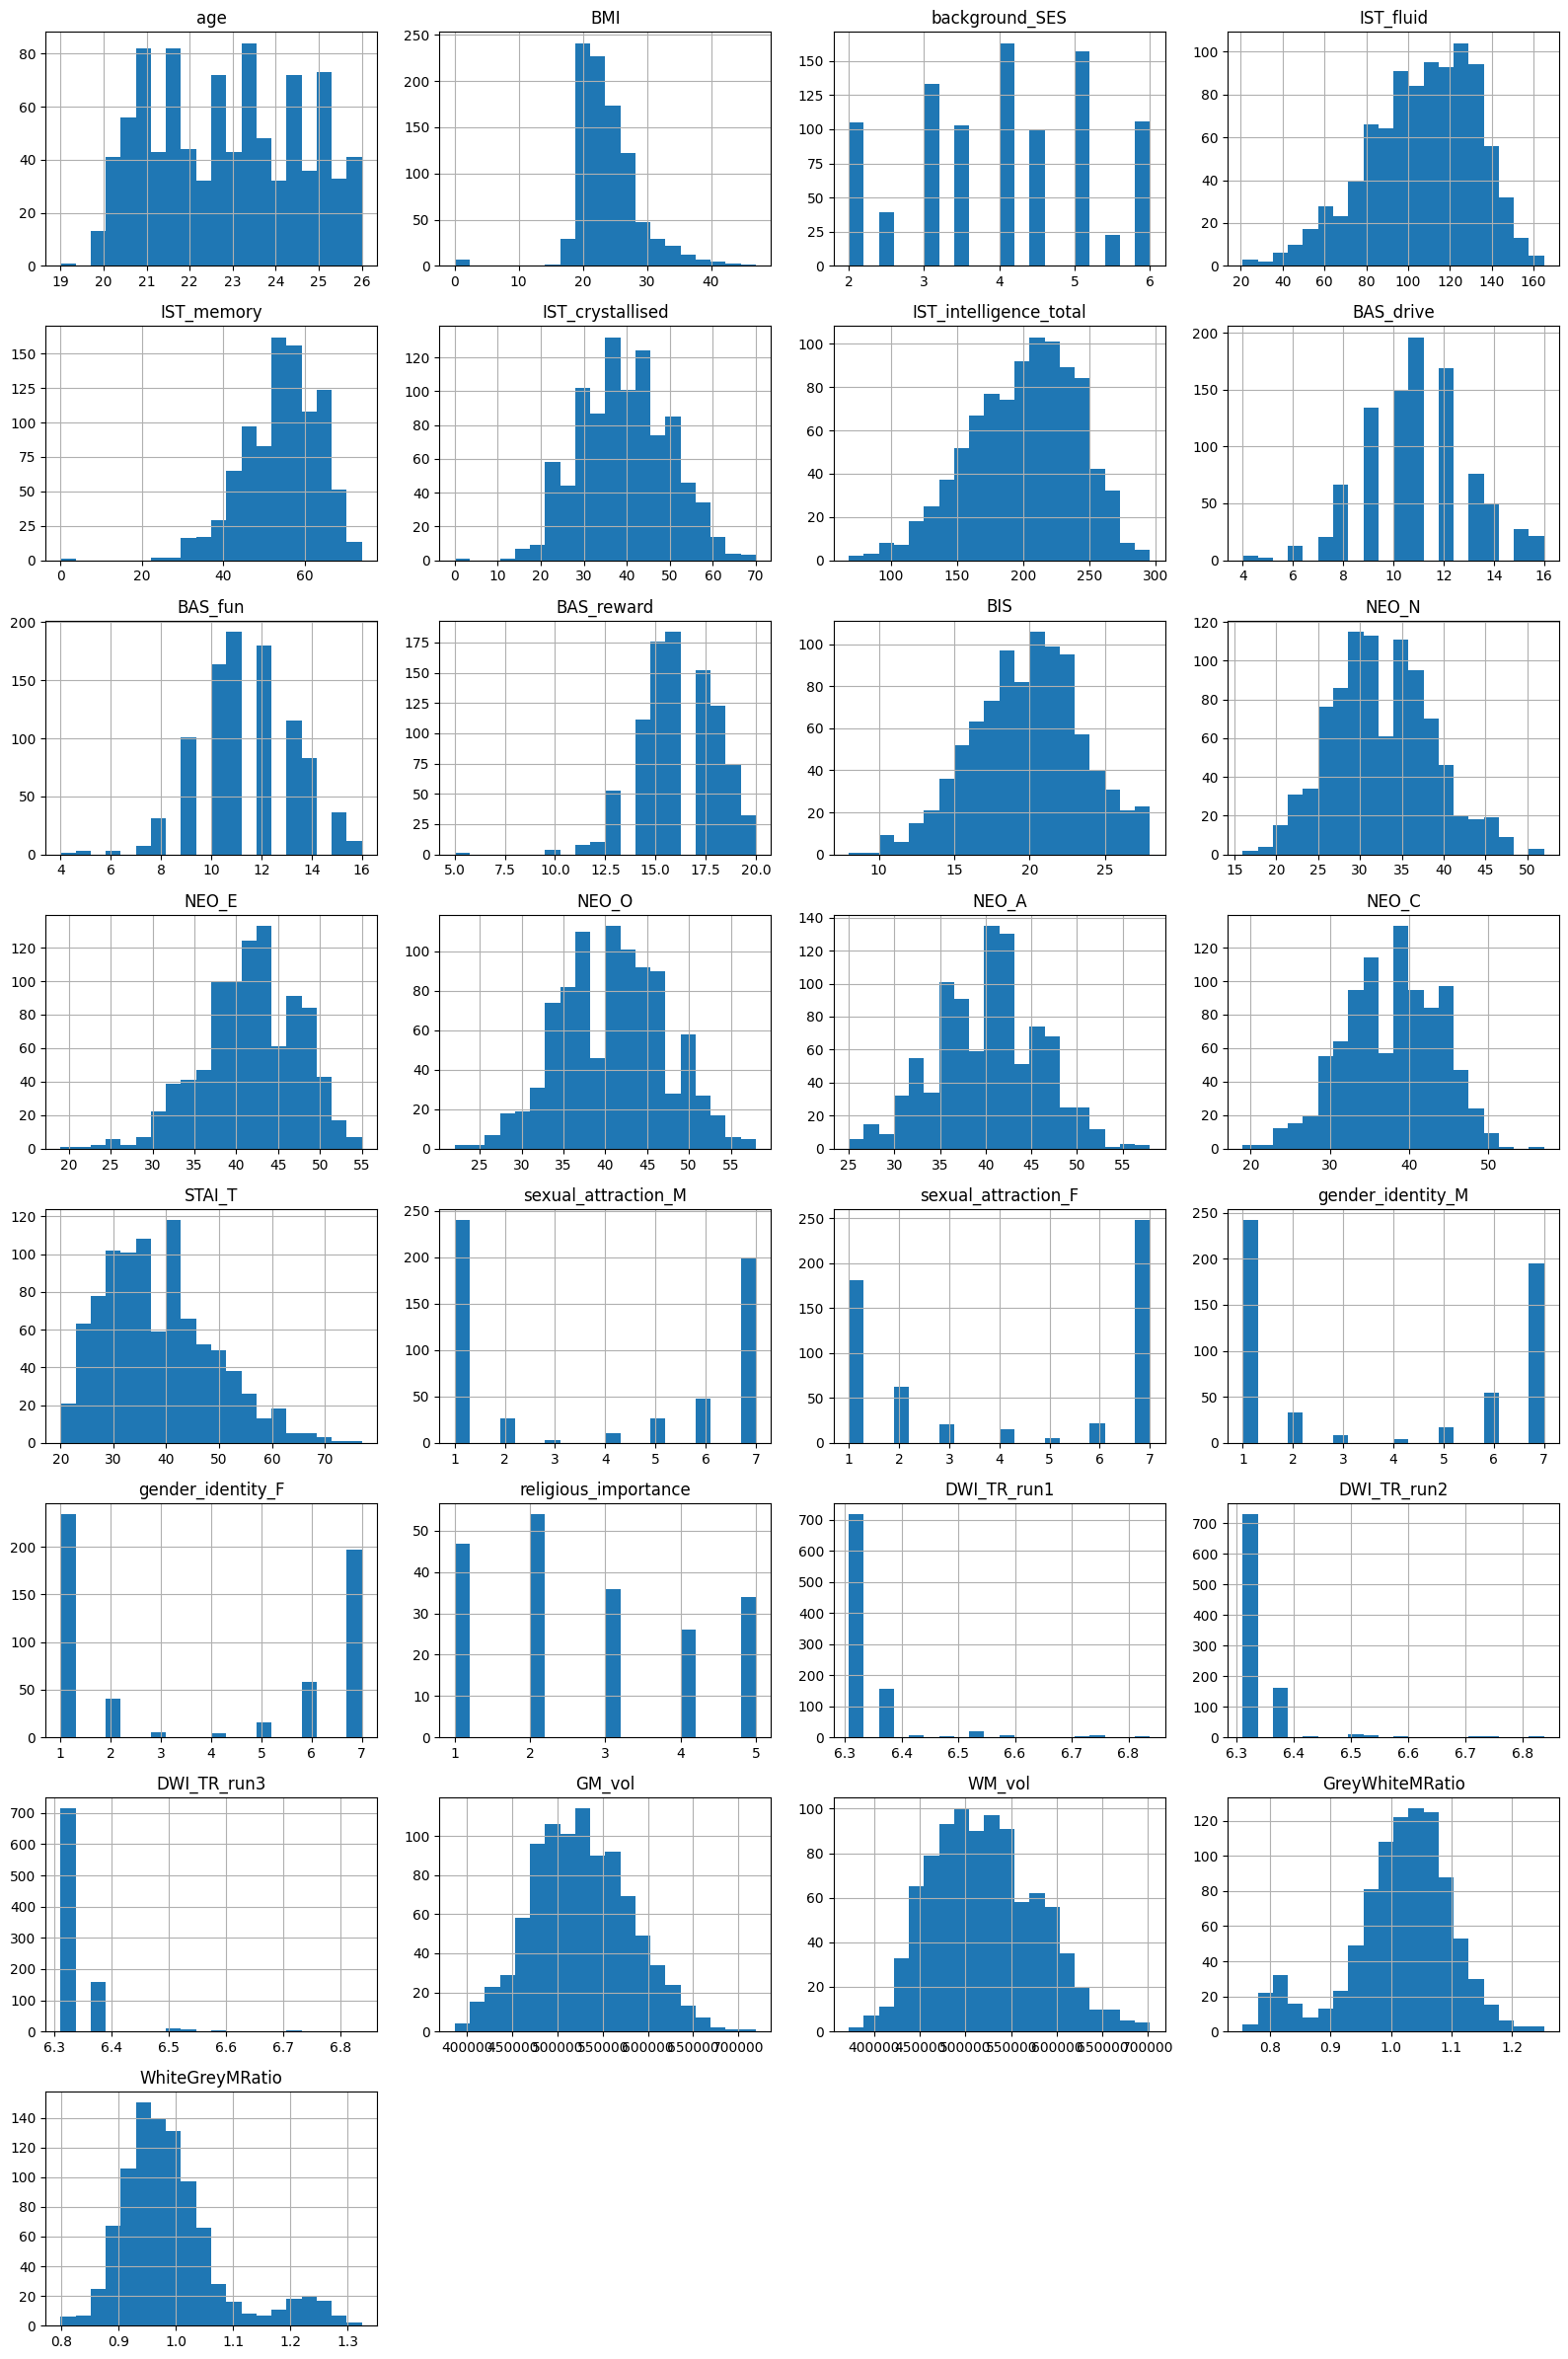

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df = pd.read_csv("AOMIC_ID1000_V2_combined(1).csv")

numerical_cols = df.select_dtypes(include=np.number).columns

n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))

axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    df[col].hist(bins=20, ax=ax)
    ax.set_title(col)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()